<a target="_blank" href="https://colab.research.google.com/github/LuoYanHao-2025/Data_Science_Group31/blob/cf37e58ed7811420f27bbcbe17ffe85a56aab8c7/Project_on_diabetes.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1 Preprocessing
## 1.1 Data Cleaning

### 1.1.1 Concatenation/Integrating
Usually we clean different dataset repectively and then concatenate them. However, the CDC questionnaire are from the surveyees with the same SEQN, which means the separate datasets are in fact one unitary dataset at first. We concatenate first thus we drop some surveyees lack of columns we care about, alleviating the work amount of data cleaning.

### 1.1.2 Drop the irrelavent **columns**

Too many columns included in the origin dataset. Only select those we use to import.

In [ ]:
import pandas as pd
import numpy as np

# Define file paths
base_path = "/content/drive/MyDrive/WIA1007_Project/"

# Dictionary mapping CDC variable codes to readable English names
# Key: CDC Code, Value: Readable Name
columns_map = {
    # --- Identifiers ---
    'SEQN': 'ID',

    # --- Target Variables (To construct the Diabetes Label) ---
    'DIQ010': 'doctor_diabetes_diagnosis',  # 1=Yes, 2=No, 3=Borderline
    'LBXGLU': 'fasting_glucose_mg_dl',      # Lab: Fasting Glucose
    'LBXGH':  'glycohemoglobin_percent',    # Lab: HbA1c (Long-term sugar)

    # --- Demographics (Easy to get) ---
    'RIDAGEYR': 'age',
    'RIAGENDR': 'gender',                   # 1=Male, 2=Female
    'INDFMPIR': 'poverty_income_ratio',     # Socioeconomic status (Family income / Poverty guideline)

    # --- Body Measures (Non-invasive) ---
    'BMXBMI':   'bmi',
    'BMXWAIST': 'waist_circumference_cm',   # Waist is a strong predictor for metabolic issues

    # --- Lifestyle: Sleep ---
    'SLD012': 'sleep_hours',

    # --- Lifestyle: Mental Health ---
    'DPQ020': 'depression_feeling_frequency', # 0=Not at all -> 3=Nearly every day

    # --- Lifestyle: Substance Use ---
    'SMQ040': 'smoking_status',             # Do you now smoke? (1=Every day, 2=Some days, 3=Not at all)
    'ALQ130': 'alcohol_drinks_per_day',     # Average alcoholic drinks per day (Past 12 mos)

    # --- Lifestyle: Physical Activity (Raw columns for calculation) ---
    'PAD680':  'sedentary_minutes_per_day',
    'PAD790Q': 'moderate_activity_freq',    # Frequency (Number)
    'PAD790U': 'moderate_activity_unit',    # Unit (Day/Week/Month)
    'PAD800':  'moderate_activity_duration',# Duration (Minutes)
    'PAD810Q': 'vigorous_activity_freq',
    'PAD810U': 'vigorous_activity_unit',
    'PAD820':  'vigorous_activity_duration'
}

# List of files to read and their specific columns to keep
# We only load columns that are in our map to save memory and avoid clutter
files_config = [
    {'path': base_path + "DIQ_L.xpt", 'cols': ['SEQN', 'DIQ010']},
    {'path': base_path + "GLU_L.xpt", 'cols': ['SEQN', 'LBXGLU']},
    {'path': base_path + "GHB_L.xpt", 'cols': ['SEQN', 'LBXGH']},
    {'path': base_path + "DEMO_L.xpt",'cols': ['SEQN', 'RIDAGEYR', 'RIAGENDR', 'INDFMPIR']},
    {'path': base_path + "BMX_L.xpt", 'cols': ['SEQN', 'BMXBMI', 'BMXWAIST']},
    {'path': base_path + "SLQ_L.xpt", 'cols': ['SEQN', 'SLD012']},
    {'path': base_path + "DPQ_L.xpt", 'cols': ['SEQN', 'DPQ020']},
    {'path': base_path + "SMQ_L.xpt", 'cols': ['SEQN', 'SMQ040']},
    {'path': base_path + "ALQ_L.xpt", 'cols': ['SEQN', 'ALQ130']},
    {'path': base_path + "PAQ_L.xpt", 'cols': ['SEQN', 'PAD680', 'PAD790Q', 'PAD790U', 'PAD800', 'PAD810Q', 'PAD810U', 'PAD820']}
]

# Read and Merge Dataframes
df_final = None

for config in files_config:
    # Read SAS file
    df_temp = pd.read_sas(config['path'])

    # Filter columns: keep only those in our list if they exist in the file
    # (Using intersection to avoid errors if a column name varies slightly)
    cols_to_keep = [c for c in config['cols'] if c in df_temp.columns]
    df_temp = df_temp[cols_to_keep]

    # Merge logic
    if df_final is None:
        df_final = df_temp
    else:
        # Outer merge to keep everyone, we will handle missing values later
        # Using 'inner' is also fine if you want strict complete cases
        df_final = pd.merge(df_final, df_temp, on='SEQN', how='outer')

# Rename Columns
df_final = df_final.rename(columns=columns_map)

In [ ]:
print(df_final.isna().sum())

ID                                 0
doctor_diabetes_diagnosis        193
fasting_glucose_mg_dl           8261
glycohemoglobin_percent         5218
age                                0
gender                             0
poverty_income_ratio            2041
bmi                             3462
waist_circumference_cm          3743
sleep_hours                     3545
depression_feeling_frequency    6415
smoking_status                  8690
alcohol_drinks_per_day          7864
sedentary_minutes_per_day       3795
moderate_activity_freq          3798
moderate_activity_unit          3780
moderate_activity_duration      5543
vigorous_activity_freq          3794
vigorous_activity_unit          3780
vigorous_activity_duration      8246
dtype: int64


The condition of data is quite well. But there are still something we need to fix:
1. The columns' titles are in CDC code, needed to be converted to human-readable text.
2. A few missing values.
3. CDC usually uses some error code, like 9999 and 7777. Drop them and replace them with 0 or Na (it denpends).

### 1.1.3 Translation

CDC utilizes some special code to represent `don't know` and `refuse`. Drop these cells and replace them with `np.na` or other default values.

In [ ]:
error_codes_map = {
    # 7/9
    'doctor_diabetes_diagnosis': [7, 9],
    'depression_feeling_frequency': [7, 9],
    'smoking_status': [7, 9],

    # 777/999
    'alcohol_drinks_per_day': [777, 999],

    # 7777/9999
    'sedentary_minutes_per_day': [7777, 9999],
    'moderate_activity_freq': [7777, 9999],
    'moderate_activity_duration': [7777, 9999],
    'vigorous_activity_freq': [7777, 9999],
    'vigorous_activity_duration': [7777, 9999]
}

for col, codes in error_codes_map.items():
    if col in df_final.columns:
        df_final[col] = df_final[col].replace(codes, np.nan)

# change the borderline to no-diabete
df_final['doctor_diabetes_diagnosis'] = df_final['doctor_diabetes_diagnosis'].replace(3, 2)

In [ ]:
df_final.head()

,ID,doctor_diabetes_diagnosis,fasting_glucose_mg_dl,glycohemoglobin_percent,age,gender,poverty_income_ratio,bmi,waist_circumference_cm,sleep_hours,depression_feeling_frequency,smoking_status,alcohol_drinks_per_day,sedentary_minutes_per_day,moderate_activity_freq,moderate_activity_unit,moderate_activity_duration,vigorous_activity_freq,vigorous_activity_unit,vigorous_activity_duration
0,130378.0,2.0,113.0,5.6,43.0,1.0,5.00,27.0,98.3,9.5,NaN,3.0,NaN,360.0,3.0,b'W',45.0,3.000000e+00,b'W',45.0
1,130379.0,2.0,99.0,5.6,66.0,1.0,5.00,33.5,114.7,9.0,5.397605e-79,3.0,3.0,480.0,4.0,b'W',45.0,3.000000e+00,b'W',45.0
2,130380.0,1.0,156.0,6.2,44.0,2.0,1.41,29.7,93.5,8.0,5.397605e-79,NaN,1.0,240.0,1.0,b'W',20.0,5.397605e-79,b'',NaN
3,130381.0,2.0,NaN,NaN,5.0,2.0,1.53,23.8,70.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,130382.0,2.0,NaN,NaN,2.0,1.0,3.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.1.4 Reduction
For activity levels, there are an extra column for unit. Convert them into one unit.

In [ ]:
# There are various Units for frequency in PA
for dictName in {"moderate_activity_unit","vigorous_activity_unit"}:
  print("\nUnique Category for "+dictName)
  print(df_final[dictName].unique())


Unique Category for moderate_activity_unit
[b'W' nan b'' b'D' b'M' b'Y']

Unique Category for vigorous_activity_unit
[b'W' b'' nan b'M' b'D' b'Y']


In [ ]:
# converting all the frequency into PER WEEK
def convert_to_weekly_frequency(df_merged):
    # converting function/formula
    def convert_frequency(freq, unit):
        # Invalid value handling
        if pd.isna(freq) or freq in [7777, 9999]:
            return np.nan

        unit_str = unit.decode('utf-8') if isinstance(unit, bytes) else str(unit)
        # if no unit, speculate it by the rule provided by CDC
        if pd.isna(unit_str) or unit_str == '':
            if freq <= 4:
                unit_str = 'D'
            elif freq <= 28:
                unit_str = 'W'
            elif freq <= 31:
                unit_str = 'M'
            elif freq <= 365:
                unit_str = 'Y'
            else:
                return np.nan

        # calculate valid rows
        if unit_str == 'D':
            return freq * 7
        elif unit_str == 'W':
            return freq
        elif unit_str == 'M':
            return freq * 4.345
        elif unit_str == 'Y':
            return freq / 52
        else:
            return np.nan

    # handle the moderate
    df_merged['moderate_activity_w'] = df_merged.apply(
        lambda row: convert_frequency(row['moderate_activity_freq'],row['moderate_activity_unit']),axis=1
    )

    # handle the vigorous
    df_merged['vigorous_activity_w'] = df_merged.apply(
        lambda row: convert_frequency(row['vigorous_activity_freq'],row['vigorous_activity_unit']),axis=1
    )

    # drop the old columns
    columns_to_drop = ['moderate_activity_freq', 'moderate_activity_unit','vigorous_activity_freq', 'vigorous_activity_unit']

    existing_columns = [col for col in columns_to_drop if col in df_merged.columns]
    df_merged = df_merged.drop(columns=existing_columns)

    return df_merged

df_final = convert_to_weekly_frequency(df_final)

In [ ]:
# Check the result
df_final.head()

,ID,doctor_diabetes_diagnosis,fasting_glucose_mg_dl,glycohemoglobin_percent,age,gender,poverty_income_ratio,bmi,waist_circumference_cm,sleep_hours,depression_feeling_frequency,smoking_status,alcohol_drinks_per_day,sedentary_minutes_per_day,moderate_activity_duration,vigorous_activity_duration,moderate_activity_w,vigorous_activity_w
0,130378.0,2.0,113.0,5.6,43.0,1.0,5.00,27.0,98.3,9.5,NaN,3.0,NaN,360.0,45.0,45.0,3.0,3.000000e+00
1,130379.0,2.0,99.0,5.6,66.0,1.0,5.00,33.5,114.7,9.0,5.397605e-79,3.0,3.0,480.0,45.0,45.0,4.0,3.000000e+00
2,130380.0,1.0,156.0,6.2,44.0,2.0,1.41,29.7,93.5,8.0,5.397605e-79,NaN,1.0,240.0,20.0,NaN,1.0,3.778324e-78
3,130381.0,2.0,NaN,NaN,5.0,2.0,1.53,23.8,70.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,130382.0,2.0,NaN,NaN,2.0,1.0,3.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The same situation on data reduction is on diagnosis of diabetes:  
Defining the Target Variable:Following the guidelines from the American Diabetes Association (ADA) and the Centers for Disease Control and Prevention (CDC), we defined a participant as having diabetes (Target=1) if they met any of the following criteria:
1. HbA1c level $\ge 6.5\%$\
2. Fasting Plasma Glucose $\ge 126$ mg/dL.
3. Self-reported diagnosis by a doctor/health professional ("Yes" to questionnaire DIQ010).  
Participants who met none of these criteria were classified as Non-Diabetic (Target=0).

In [ ]:
def define_diabetes_label(row):
    doctor_said = row['doctor_diabetes_diagnosis']   # 1=Yes, 2=No
    hba1c = row['glycohemoglobin_percent']       # Threshold: 6.5
    glucose = row['fasting_glucose_mg_dl']       # Threshold: 126

    if doctor_said == 1:
        return 1

    if pd.notna(hba1c) and hba1c >= 6.5:
        return 1

    if pd.notna(glucose) and glucose >= 126:
        return 1

    if pd.isna(doctor_said) and pd.isna(hba1c) and pd.isna(glucose):
        return np.nan

    return 0

df_final['diabetes_target'] = df_final.apply(define_diabetes_label, axis=1)

# Drop those cannot be diagnosed. They may disturb our result.
original_len = len(df_final)
print(f"{original_len} samples in total")
df_final = df_final.dropna(subset=['diabetes_target'])
print(f" {original_len - len(df_final)} samples are dropped.")

11933 samples in total
 196 samples are dropped.


In [ ]:
columns_to_drop = ['doctor_diabetes_diagnosis', 'fasting_glucose_mg_dl','glycohemoglobin_percent']

existing_columns = [col for col in columns_to_drop if col in df_final.columns]
df_final = df_final.drop(columns=existing_columns)

There are some extremely small numbers which are supposed to be errors. Replace them with 0 (notice that cells with extremely small numbers are usually with some NaN in the same line, making it be 0 reasonable, supporting our operation).

In [ ]:
df_final = df_final.map(lambda x: 0 if isinstance(x, (int, float)) and abs(x) < 1e-5 else x)

In [ ]:
df_final.head()

,ID,age,gender,poverty_income_ratio,bmi,waist_circumference_cm,sleep_hours,depression_feeling_frequency,smoking_status,alcohol_drinks_per_day,sedentary_minutes_per_day,moderate_activity_duration,vigorous_activity_duration,moderate_activity_w,vigorous_activity_w,diabetes_target
0,130378.0,43.0,1.0,5.00,27.0,98.3,9.5,NaN,3.0,NaN,360.0,45.0,45.0,3.0,3.0,0.0
1,130379.0,66.0,1.0,5.00,33.5,114.7,9.0,0.0,3.0,3.0,480.0,45.0,45.0,4.0,3.0,0.0
2,130380.0,44.0,2.0,1.41,29.7,93.5,8.0,0.0,NaN,1.0,240.0,20.0,NaN,1.0,0.0,1.0
3,130381.0,5.0,2.0,1.53,23.8,70.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,130382.0,2.0,1.0,3.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


### 1.1.4 Filling the missing Values
NA with a related column value 0 is a 0 which is given by subject who feel confused with refill the same thing or generated by computer system automatically.

In [ ]:
activity_pairs = [
    ('moderate_activity_duration', 'moderate_activity_w'),
    ('vigorous_activity_duration', 'vigorous_activity_w')
]

for minutes, weekly in activity_pairs:
    # time = 0, then frequency should be 0
    df_final.loc[df_final[minutes] == 0, weekly] = 0
    # freq = 0, then time should be 0
    df_final.loc[df_final[weekly] == 0, minutes] = 0
    # when one of it is 0, the other is NA, the NA one is 0(the surveyee was confused so leaving it empty)
    df_final.loc[(df_final[minutes].isna()) & (df_final[weekly] == 0), minutes] = 0
    df_final.loc[(df_final[weekly].isna()) & (df_final[minutes] == 0), weekly] = 0

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11737 entries, 0 to 11932
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            11737 non-null  float64
 1   age                           11737 non-null  float64
 2   gender                        11737 non-null  float64
 3   poverty_income_ratio          9728 non-null   float64
 4   bmi                           8470 non-null   float64
 5   waist_circumference_cm        8189 non-null   float64
 6   sleep_hours                   8387 non-null   float64
 7   depression_feeling_frequency  5508 non-null   float64
 8   smoking_status                3242 non-null   float64
 9   alcohol_drinks_per_day        4055 non-null   float64
 10  sedentary_minutes_per_day     8064 non-null   float64
 11  moderate_activity_duration    8066 non-null   float64
 12  vigorous_activity_duration    8085 non-null   float64
 13  modera

We have to drop columns Smoke and Alcohol because there are too much missing data to be reliable.

In [ ]:
cols_to_drop = ['smoking_status', 'alcohol_drinks_per_day']
df_final = df_final.drop(columns=cols_to_drop)

In [ ]:
# sleep: yes! sedentary also is considered as sleep logically
median_colums = ["sleep_hours",'sedentary_minutes_per_day','bmi','poverty_income_ratio']
mode_colums = ['vigorous_activity_duration', 'moderate_activity_w','moderate_activity_duration', 'vigorous_activity_w']

for col in median_colums:
  df_final[col] = df_final[col].fillna(df_final[col].median())

for col in mode_colums:
  df_final[col] = df_final[col].fillna(df_final[col].mode()[0])

df_final['depression_feeling_frequency'] = df_final['depression_feeling_frequency'].fillna(0)

# drop the most significant factors to lower the twist on original data
df_final = df_final.dropna(subset = ['waist_circumference_cm'])

In [ ]:
df_final = df_final.drop_duplicates()

In [ ]:
df_final = df_final.reset_index(drop=True)

In [ ]:
df_final = df_final.drop(columns = ['ID'])

In [ ]:
df_final.describe()

,age,gender,poverty_income_ratio,bmi,waist_circumference_cm,sleep_hours,depression_feeling_frequency,sedentary_minutes_per_day,moderate_activity_duration,vigorous_activity_duration,moderate_activity_w,vigorous_activity_w,diabetes_target
count,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000
mean,40.904140,1.532055,2.740259,27.143913,92.123031,7.794969,0.299792,345.697399,53.672121,20.491513,3.324302,1.448910,0.124679
std,24.489671,0.499002,1.558691,7.949405,22.050931,1.376323,0.652960,177.988547,50.904979,45.573604,6.590467,4.012743,0.330375
min,2.000000,1.000000,0.000000,11.100000,39.800000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,1.000000,1.430000,21.600000,77.500000,7.000000,0.000000,240.000000,30.000000,0.000000,0.000000,0.000000,0.000000
50%,41.000000,2.000000,2.500000,26.400000,92.700000,8.000000,0.000000,300.000000,60.000000,0.000000,2.000000,0.000000,0.000000
75%,63.000000,2.000000,4.310000,31.600000,107.000000,8.000000,0.000000,420.000000,60.000000,30.000000,4.345000,2.000000,0.000000
max,80.000000,2.000000,5.000000,69.900000,187.000000,14.000000,3.000000,1320.000000,720.000000,900.000000,140.000000,104.280000,1.000000


### 1.1.5 Outliers
1. There are some extreme data in which the subject's sedentary time per day is 22 hours. It is unreasonable. IQR will be applied to all the extreme rows.
2. There are infants in the dataset. But in this project we focusing on lifestyle and diabetes. The Congenital Diabetes are not within the consideration.

Caution: Q3 of `vigorous_activity_duration`,`moderate_activity_w`,`vigorous_activity_w` are 0, they are not applicable for IQR. Capping the frequency with 28(per week = 4 times per day).

In [ ]:
# drop the teenagers and infants
df_final = df_final[df_final['age'] >= 18]

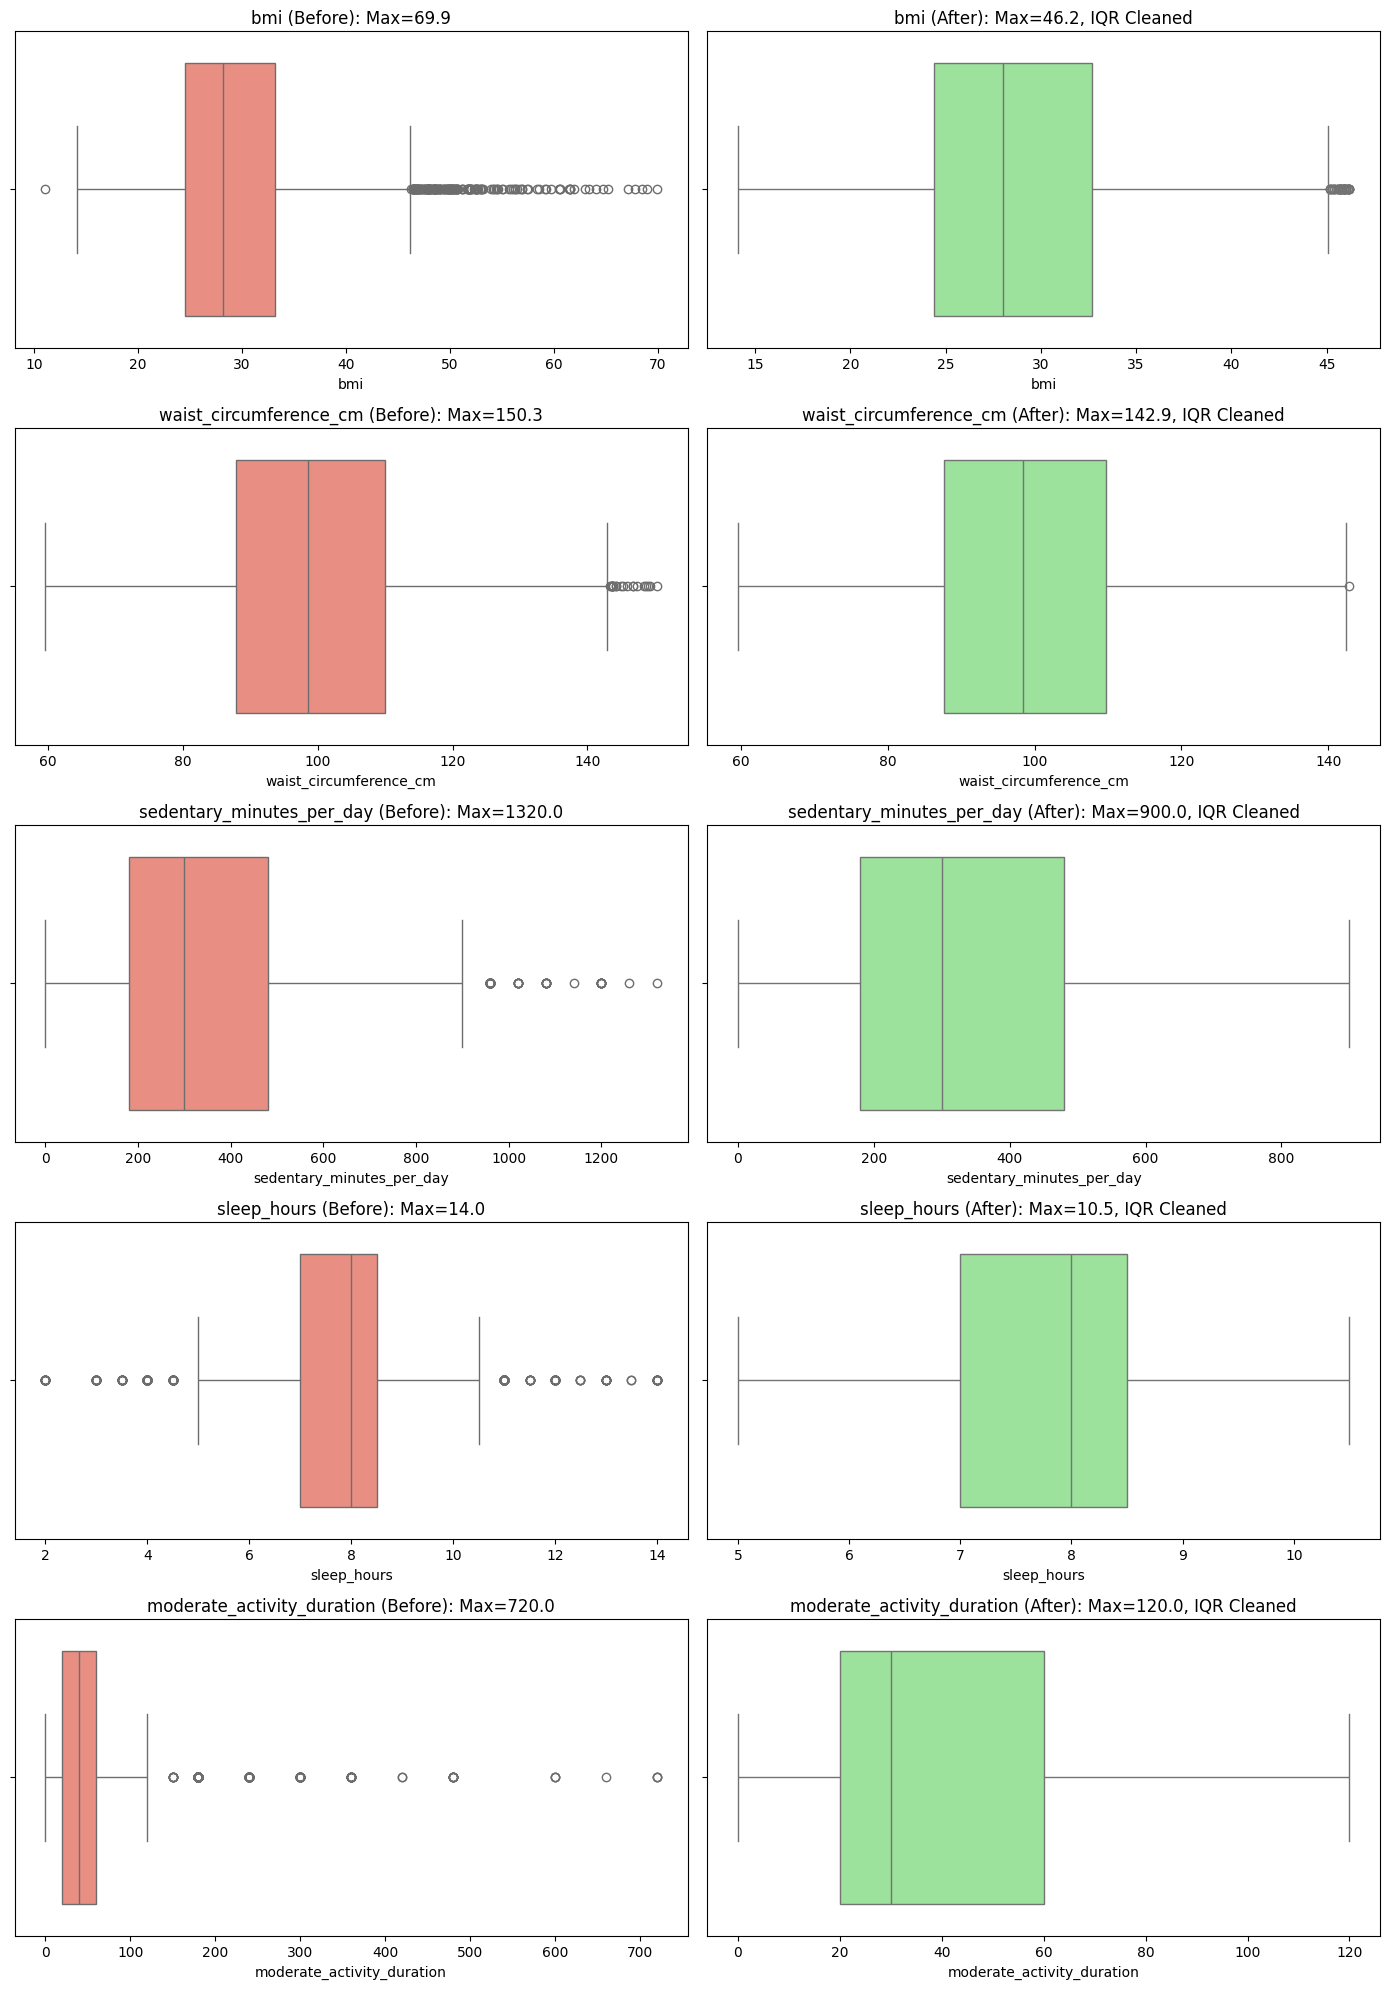

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

iqr_cols = [
    'bmi',
    'waist_circumference_cm',
    'sedentary_minutes_per_day',
    'sleep_hours',
    'moderate_activity_duration'
]

plt.figure(figsize=(14, 4 * len(iqr_cols)))
df_clean = df_final.copy()

for i, col in enumerate(iqr_cols):
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    original_data = df_clean[col].copy()

    df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

    ax1 = plt.subplot(len(iqr_cols), 2, 2*i + 1)
    sns.boxplot(x=original_data, ax=ax1, color='salmon')
    ax1.set_title(f'{col} (Before): Max={original_data.max():.1f}')

    ax2 = plt.subplot(len(iqr_cols), 2, 2*i + 2)
    sns.boxplot(x=df_clean[col], ax=ax2, color='lightgreen')
    ax2.set_title(f'{col} (After): Max={df_clean[col].max():.1f}, IQR Cleaned')

plt.tight_layout()
plt.show()

df_final = df_clean

limit =28   # 28/week = 4 /day a very high frequency, No higher freq is allowed
for col in ['moderate_activity_w','vigorous_activity_w']:
  df_final[col] = df_final[col].clip(upper=limit)

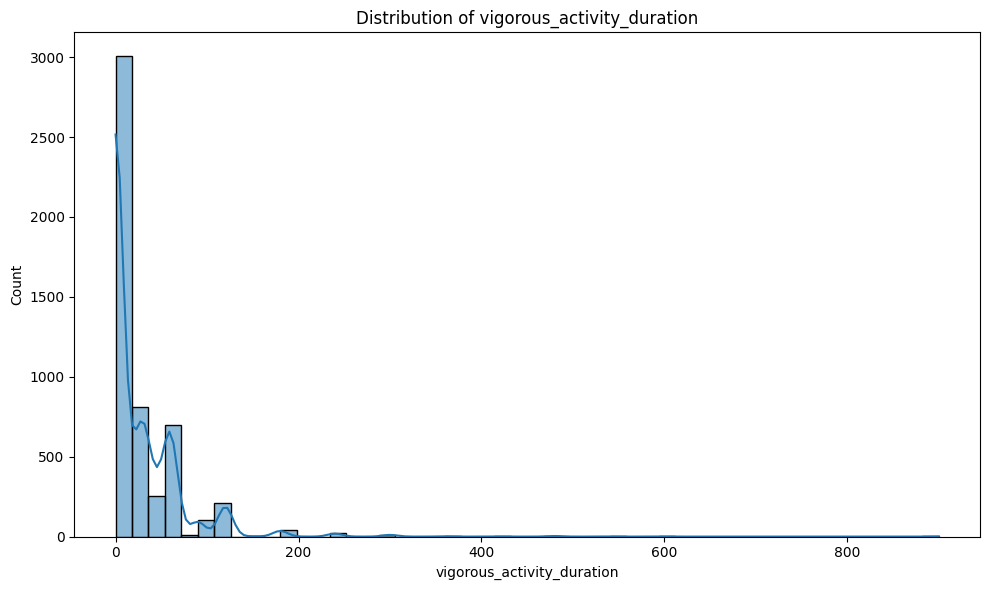

In [ ]:
# Display the distribution pattern of column: vigorous_activity_duration
# To explore the reasonable upper limit
plt.figure(figsize=(10, 6))
sns.histplot(df_final['vigorous_activity_duration'], bins=50, kde=True)
plt.title('Distribution of vigorous_activity_duration')
plt.tight_layout()
plt.show()

It is clear that data over 250 can be considered as outliers. But in case that there are some "superman" doing a extremely large amount of exercise, capping those beyong 250 to 250.

In [ ]:
limit = 250
df_final['vigorous_activity_duration'] = df_final['vigorous_activity_duration'].clip(upper=limit)

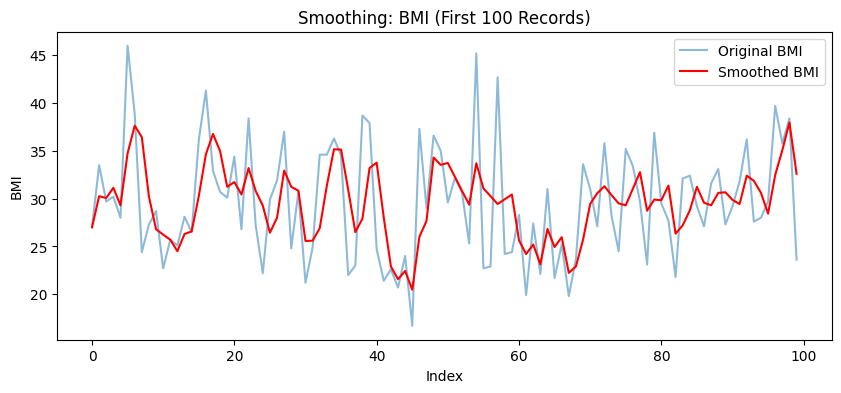

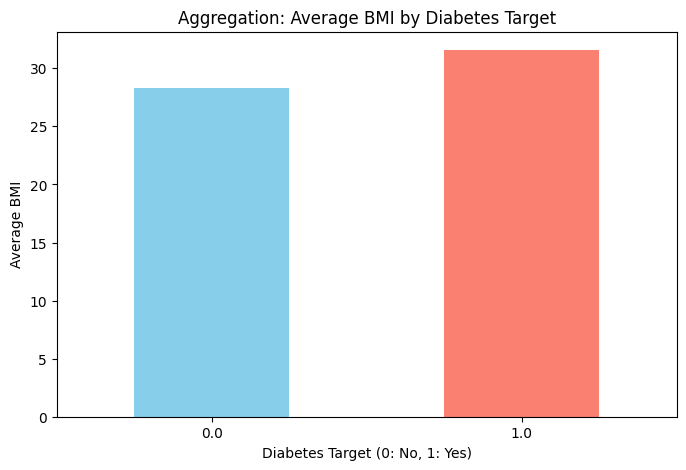

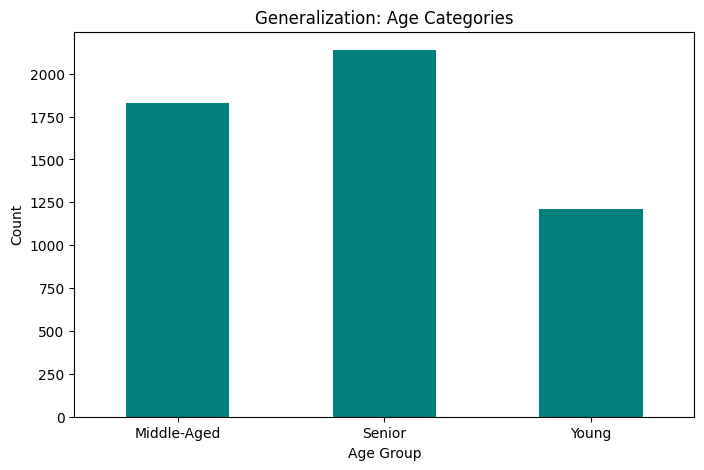

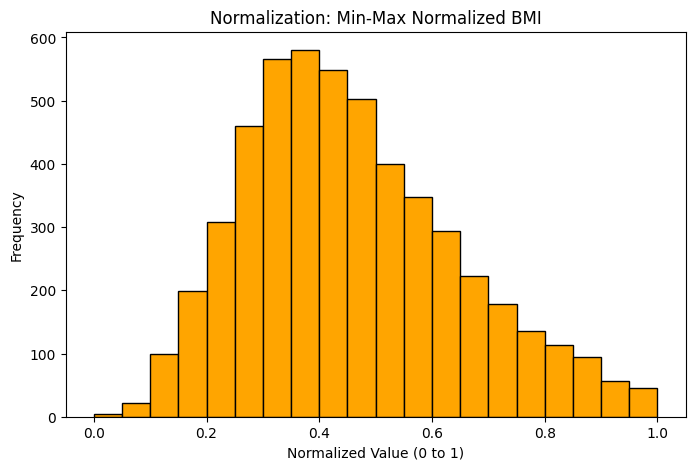

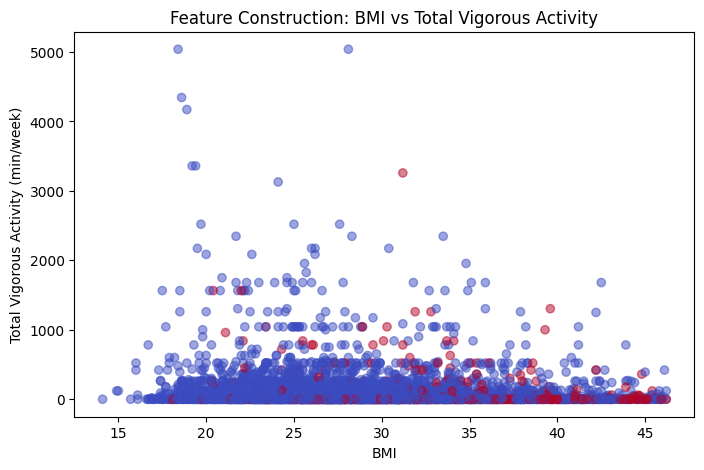

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# 1. SMOOTHING
# ===============================
# We smooth 'bmi' to see the general trend across the dataset
df_final["bmi_Smoothed"] = df_final["bmi"].rolling(
    window=3, min_periods=1
).mean()

plt.figure(figsize=(10, 4))
plt.plot(df_final["bmi"].iloc[:100].values, label="Original BMI", alpha=0.5)
plt.plot(df_final["bmi_Smoothed"].iloc[:100].values, label="Smoothed BMI", color='red')
plt.title("Smoothing: BMI (First 100 Records)")
plt.xlabel("Index")
plt.ylabel("BMI")
plt.legend()
plt.show()

# ===============================
# 2. AGGREGATION
# ===============================
# Aggregating the average BMI based on Diabetes Status
# 0 = Non-Diabetic, 1 = Diabetic
aggregation = df_final.groupby("diabetes_target").mean(numeric_only=True)

plt.figure(figsize=(8, 5))
aggregation["bmi"].plot(kind="bar", color=['skyblue', 'salmon'])
plt.title("Aggregation: Average BMI by Diabetes Target")
plt.xlabel("Diabetes Target (0: No, 1: Yes)")
plt.ylabel("Average BMI")
plt.xticks(rotation=0)
plt.show()

# ===============================
# 3. GENERALIZATION
# ===============================
# Generalizing 'age' into categories
def age_category(age):
    if age <= 35:
        return "Young"
    elif age <= 60:
        return "Middle-Aged"
    else:
        return "Senior"

df_final["Age Category"] = df_final["age"].apply(age_category)

plt.figure(figsize=(8, 5))
df_final["Age Category"].value_counts().sort_index().plot(kind="bar", color='teal')
plt.title("Generalization: Age Categories")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

# ===============================
# 4. NORMALIZATION (Min-Max)
# ===============================
# Normalizing 'bmi' so that all values fall between 0 and 1
df_final["bmi_MinMax"] = (
    df_final["bmi"] - df_final["bmi"].min()
) / (
    df_final["bmi"].max() - df_final["bmi"].min()
)

plt.figure(figsize=(8, 5))
plt.hist(df_final["bmi_MinMax"], bins=20, color='orange', edgecolor='black')
plt.title("Normalization: Min-Max Normalized BMI")
plt.xlabel("Normalized Value (0 to 1)")
plt.ylabel("Frequency")
plt.show()

# ===============================
# 5. FEATURE CONSTRUCTION
# ===============================
# Constructing 'Total Vigorous Activity' per week
# Formula: Duration per session * Frequency per week
df_final["Total_Vigorous_Activity"] = df_final["vigorous_activity_duration"] * df_final["vigorous_activity_w"]

plt.figure(figsize=(8, 5))
plt.scatter(df_final["bmi"], df_final["Total_Vigorous_Activity"], alpha=0.5, c=df_final["diabetes_target"], cmap='coolwarm')
plt.title("Feature Construction: BMI vs Total Vigorous Activity")
plt.xlabel("BMI")
plt.ylabel("Total Vigorous Activity (min/week)")
plt.show()

## 1.2 Pre-normalization

For the machine learning, the data should be normalized to optimize the efficiency of training and maximize the precision of prediction/prescription.

But normalizing some of the data here may do inconvenience on EDA, impair the intuitiveness carried with the number.

Therefore, here we only normalize one property: `gender` from catagory {1,2} (1 for male, 2 for female) to a one-hot encoding pattern {0,1} (0 for male, 1 for female).

In [ ]:
df_final['gender']=df_final['gender'].map({1:0,2:1})

In [ ]:
output_path = base_path + "cleaned_diabetes.csv"
df_final.to_csv(output_path, index=False)

# 2 EDA

Check number of rows

In [ ]:
print ('\nNo of rows in cleaned_diabetes.csv DataFrame:')
# Print number of rows in cleaned_diabetes.csv DataFrame
print(len(df_final))



No of rows in cleaned_diabetes.csv DataFrame:
5178


Analysing each column

In [ ]:
# USERID is an identifier (not a feature). We drop it to avoid using it in analysis.
df_final.columns

Index(['age', 'gender', 'poverty_income_ratio', 'bmi',
       'waist_circumference_cm', 'sleep_hours', 'depression_feeling_frequency',
       'sedentary_minutes_per_day', 'moderate_activity_duration',
       'vigorous_activity_duration', 'moderate_activity_w',
       'vigorous_activity_w', 'diabetes_target', 'bmi_Smoothed',
       'Age Category', 'bmi_MinMax', 'Total_Vigorous_Activity'],
      dtype='object')

# Analysing each features



In [ ]:
# Count unique values in each column (helps identify categorical vs numeric features)
for feature in df_final.columns:
  len_feature = df_final[feature].nunique()
  print(f'{feature}: {len_feature}')

age: 63
gender: 2
poverty_income_ratio: 454
bmi: 301
waist_circumference_cm: 725
sleep_hours: 12
depression_feeling_frequency: 4
sedentary_minutes_per_day: 37
moderate_activity_duration: 40
vigorous_activity_duration: 31
moderate_activity_w: 35
vigorous_activity_w: 34
diabetes_target: 2
bmi_Smoothed: 2453
Age Category: 3
bmi_MinMax: 301
Total_Vigorous_Activity: 146


In [ ]:
# (Optional) Create empty lists for later use
feature_small = []
feature_large = []

# Still printing unique counts (same idea as above)
for feature in df_final.columns:
  x = df_final[feature].nunique()
  print(f'{feature}: {x}')

age: 63
gender: 2
poverty_income_ratio: 454
bmi: 301
waist_circumference_cm: 725
sleep_hours: 12
depression_feeling_frequency: 4
sedentary_minutes_per_day: 37
moderate_activity_duration: 40
vigorous_activity_duration: 31
moderate_activity_w: 35
vigorous_activity_w: 34
diabetes_target: 2
bmi_Smoothed: 2453
Age Category: 3
bmi_MinMax: 301
Total_Vigorous_Activity: 146


Split into small & large list

In [ ]:
# This code splits into small and large lists and prints the lists
feature_small = []
feature_large = []

for feature in df_final.columns:
  len_feature = df_final[feature].nunique()

  if (len_feature <= 10 ):
    feature_small.append([feature, len_feature])
  else:
    feature_large.append([feature, len_feature])

print('----Feature small----')
for item in feature_small:
  print(item)

print('\n-----Feature large------')
for item in feature_large:
  print(item)


----Feature small----
['gender', 2]
['depression_feeling_frequency', 4]
['diabetes_target', 2]
['Age Category', 3]

-----Feature large------
['age', 63]
['poverty_income_ratio', 454]
['bmi', 301]
['waist_circumference_cm', 725]
['sleep_hours', 12]
['sedentary_minutes_per_day', 37]
['moderate_activity_duration', 40]
['vigorous_activity_duration', 31]
['moderate_activity_w', 35]
['vigorous_activity_w', 34]
['bmi_Smoothed', 2453]
['bmi_MinMax', 301]
['Total_Vigorous_Activity', 146]


## 2.1 Univariate

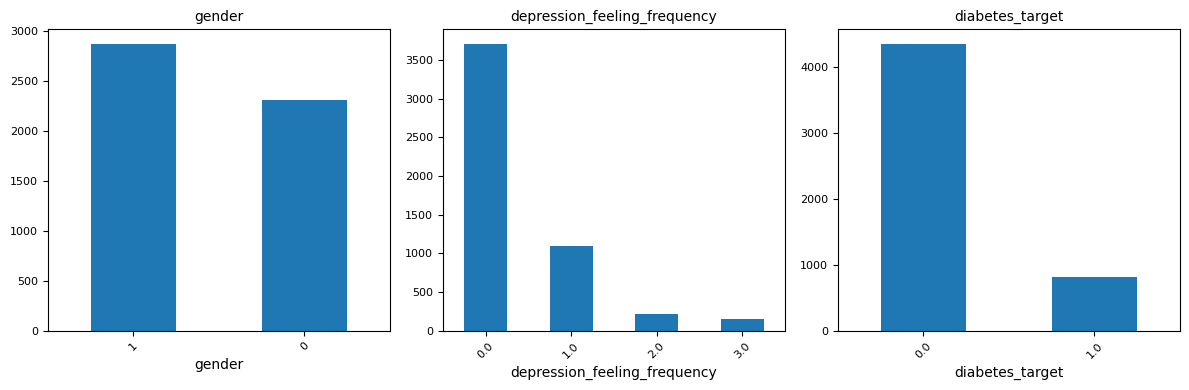

In [ ]:
import matplotlib.pyplot as plt

# Plot a few 'small' (low-unique) categorical columns using subplots
# We limit to the first 6 columns so the 2x3 grid does not overflow.
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes = axes.flatten()

for k, item in enumerate(feature_small[:3]):
  column_name = item[0]
  df_final[column_name].value_counts().plot(
      kind='bar', ax=axes[k], fontsize=8, rot=45
  )
  axes[k].set_title(column_name, fontsize=10)

plt.tight_layout()
plt.show()

## 2.2 Bivariate Analysis

B1 - bmi and age by diabetes

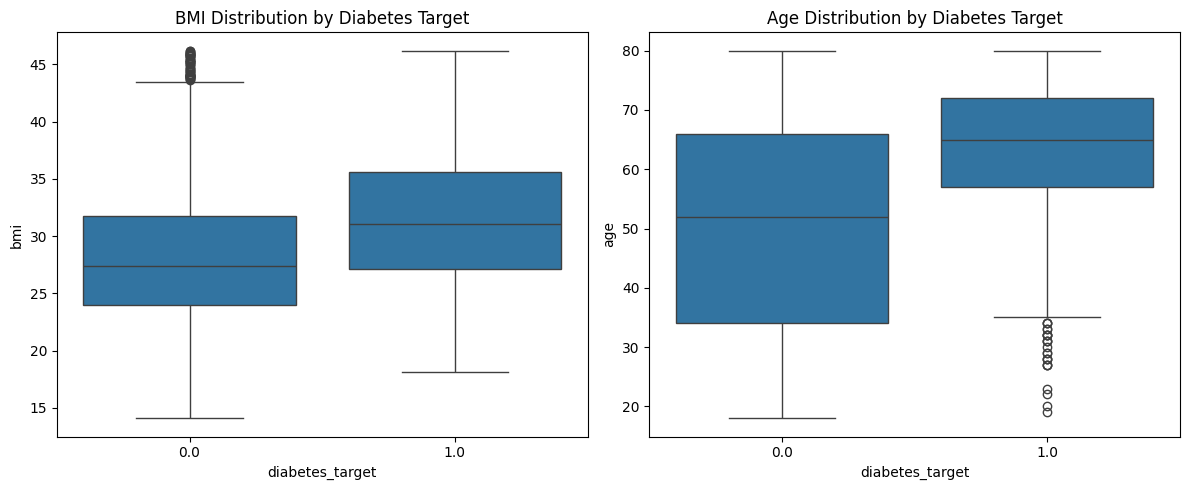

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# --- B1) Numerical distributions by Target (Boxplots) ---
# Similar to Salary vs Gender in Tutorial 9
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='diabetes_target', y='bmi', data=df_final)
plt.title('BMI Distribution by Diabetes Target')

plt.subplot(1, 2, 2)
sns.boxplot(x='diabetes_target', y='age', data=df_final)
plt.title('Age Distribution by Diabetes Target')

plt.tight_layout()
plt.savefig('bivariate_boxplots.png')
plt.show()







B2 - diabetes by gender

Mean Diabetes Target by Gender:
gender
0    0.177720
1    0.142459
Name: diabetes_target, dtype: float64


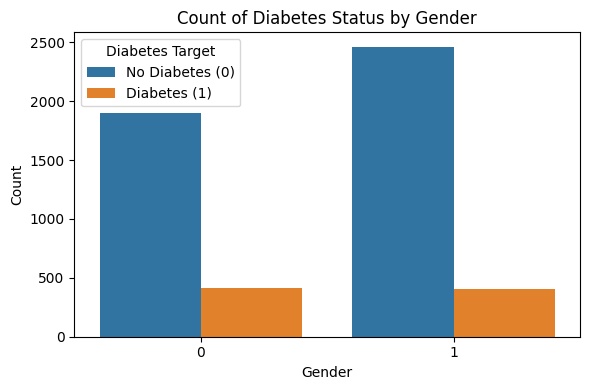

In [ ]:

gender_mean = df_final.groupby('gender')['diabetes_target'].mean()
print("Mean Diabetes Target by Gender:")
print(gender_mean)

# To see the actual number of individuals with/without diabetes in each gender
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', hue='diabetes_target', data=df_final)
plt.title("Count of Diabetes Status by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title='Diabetes Target', labels=['No Diabetes (0)', 'Diabetes (1)'])
plt.tight_layout()
plt.show()

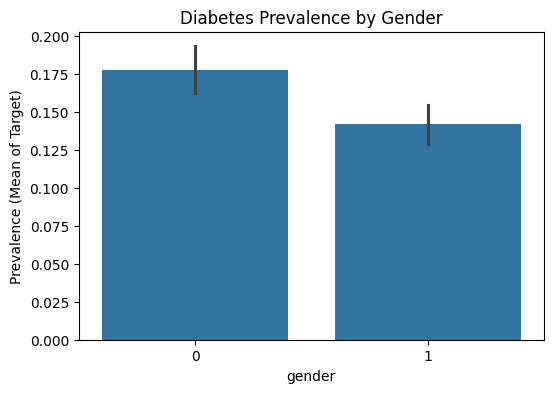

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- B3) Mean Comparison (Bar Chart) ---
plt.figure(figsize=(6, 4))
sns.barplot(x='gender', y='diabetes_target', data=df_final)
plt.title('Diabetes Prevalence by Gender')
plt.ylabel('Prevalence (Mean of Target)')
plt.savefig('bivariate_bar_gender.png')
plt.show()

## 2.3 Multivariate Analysis

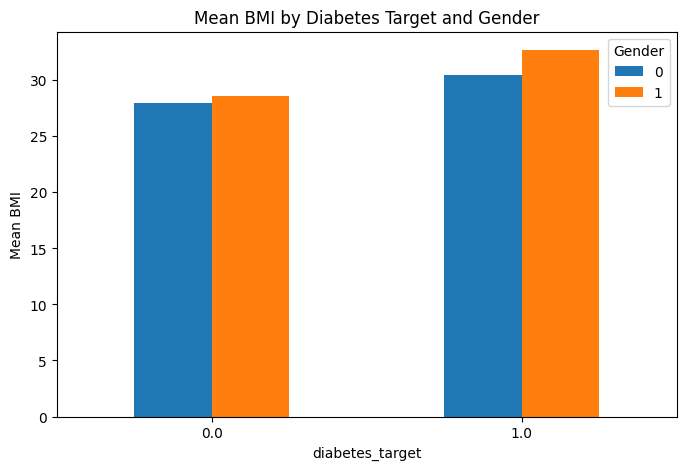

In [ ]:

# --- B4) Multivariate View (Grouped Bar Chart) ---
# Mean BMI grouped by both Diabetes status and Gender
pivot_table = df_final.pivot_table(values='bmi', index='diabetes_target', columns='gender', aggfunc='mean')
pivot_table.plot(kind='bar', figsize=(8, 5))
plt.title('Mean BMI by Diabetes Target and Gender')
plt.ylabel('Mean BMI')
plt.legend(title='Gender')
plt.xticks(rotation=0)
plt.savefig('bivariate_grouped_bar.png')
plt.show()

Exploratory Data Analysis (EDA) Tutorial — Bivariate Data Analysis

In [ ]:
import pandas as pd
import numpy as np

# Reload df_final to ensure 'age' and 'bmi' are numerical
# The cleaned_diabetes.csv file contains the DataFrame before categorical binning
output_path = "/content/drive/MyDrive/WIA1007_Project/cleaned_diabetes.csv"
df_final = pd.read_csv(output_path)

# ---------------------------------------------------------
# 2. YOUR FUNCTION (Corrected logic)
# ---------------------------------------------------------
def midpoint_from_bin(text):
    """Convert a bin string (e.g., '25-34') into a number (e.g., 29.5)."""
    if pd.isna(text):
        return np.nan
    s = str(text).strip().lower()

    # Special phrases
    if "under 18" in s: return 16.0
    if "under 18.5" in s: return 16.0
    if "65" in s and ("over" in s or "or over" in s): return 67.5
    if "30" in s and ("over" in s or "more" in s): return 35.0

    # Standard number ranges (e.g., "25-34")
    s = s.replace("years", "").replace("year", "").replace(" ", "")
    if "-" in s:
        parts = s.split("-")
        try:
            a = float(parts[0])
            b = float(parts[1])
            return (a + b) / 2.0
        except:
            return np.nan
    return np.nan

# ---------------------------------------------------------
# 3. CREATE SAFE NEW COLUMNS (Avoiding name conflicts)
# ---------------------------------------------------------

# --- Step A: Create the Text Ranges (The "Bin" columns) ---
# We look at your original 'age' (lowercase) and create a new column called 'Age_Text_Range'
age_bin = [0, 18, 25, 35, 45, 55, 65, 120]
age_label = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65 or over']
df_final['Age_Range'] = pd.cut(df_final['age'], bins=age_bin, labels=age_label, right=False)

# We look at 'bmi' and create 'BMI_Text_Range'
bmi_bin = [0, 18.5, 25, 30, 100]
bmi_label = ['Under 18.5', '18.5-24.9', '25-29.9', '30 or over']
df_final['BMI_Range'] = pd.cut(df_final['bmi'], bins=bmi_bin, labels=bmi_label, right=False)

# --- Step B: Calculate Midpoints from those Text Ranges ---
# We apply the function to the NEW text columns we just made
df_final['Age_Midpoint'] = df_final['Age_Range'].apply(midpoint_from_bin)
df_final['BMI_Midpoint'] = df_final['BMI_Range'].apply(midpoint_from_bin)


# We display: Original -> Text Range -> Calculated Midpoint
cols_to_show = ['age', 'Age_Range' , 'Age_Midpoint',
                'bmi', 'BMI_Range' , 'BMI_Midpoint']

print(df_final[cols_to_show].head(10))

    age   Age_Range Age_Midpoint   bmi   BMI_Range BMI_Midpoint
0  43.0       35-44         39.5  27.0     25-29.9        27.45
1  66.0  65 or over         67.5  33.5  30 or over        35.00
2  44.0       35-44         39.5  29.7     25-29.9        27.45
3  34.0       25-34         29.5  30.2  30 or over        35.00
4  59.0       55-64         59.5  28.0     25-29.9        27.45
5  31.0       25-34         29.5  46.0  30 or over        35.00
6  33.0       25-34         29.5  38.9  30 or over        35.00
7  51.0       45-54         49.5  24.4   18.5-24.9        21.70
8  56.0       55-64         59.5  27.3     25-29.9        27.45
9  47.0       45-54         49.5  28.7     25-29.9        27.45


3) Correlation analysis (numeric–numeric)
Correlation answers: When X increases, does Y tend to increase or decrease?

Pearson correlation (r) ranges from -1 to +1
* r > 0 → positive association
* r < 0 → negative association
* r ≈ 0 → no linear association

We'll also compute a p-value to test if correlation is statistically different from 0.

In [ ]:
# Choose numeric columns we care about today
candidate_numeric = [
    "age", "poverty_income_ratio", "bmi",
    "waist_circumference_cm", "sleep_hours",
    "sedentary_minutes_per_day", "moderate_activity_duration",
    "vigorous_activity_duration", "moderate_activity_w",
    "vigorous_activity_w", "Age_Midpoint", "BMI_Midpoint"
]

num_cols = [c for c in candidate_numeric if c in df_final.columns]
df_num = df_final[num_cols].copy()

df_num.describe().T

,count,mean,std,min,25%,50%,75%,max
age,5178.0,52.296640,18.150841,18.0,37.00,56.0,67.000,80.0
poverty_income_ratio,5178.0,2.933490,1.553687,0.0,1.71,2.5,4.795,5.0
bmi,5178.0,28.794844,6.037334,14.1,24.30,27.9,32.600,46.2
waist_circumference_cm,5178.0,98.869003,15.391579,59.6,87.50,98.3,109.500,142.9
sleep_hours,5178.0,7.749903,1.202070,5.0,7.00,8.0,8.500,10.5
sedentary_minutes_per_day,5178.0,354.912708,191.501714,0.0,240.00,300.0,480.000,900.0
moderate_activity_duration,5178.0,42.604867,34.218936,0.0,20.00,30.0,60.000,120.0
vigorous_activity_duration,5178.0,25.580919,39.803818,0.0,0.00,0.0,45.000,250.0
moderate_activity_w,5178.0,4.247020,4.988954,0.0,1.00,3.0,5.000,28.0
vigorous_activity_w,5178.0,1.892449,3.571388,0.0,0.00,0.0,3.000,28.0


### 2.2.2 Spearman Correlation

From the heatmap, we can preliminarily conclude that:
1. Age, bmi, activity level, and waist circum are the most significant factors.
2. Gender, sleep duration, depression level, sedentary level have little to do with diabetes.
3. BMI and waist circum are highly linear related, which implicated that they contains similar information. Therefore, we have to choose exactly one of them in machine learning model training, or it may lead significant instability on the model.
4. Variables about activity level are remarkably related to each other to. Thus we tend to apply the multiplication of each sort of frequency and duration, namely the totall excercise time per week, as a single variable. However, the correlation of frequency and duration of moderate activity is quite interesting, implicating that for low & middle-level exercise, the duration of each excercise help resist diabetes more than the frequency.

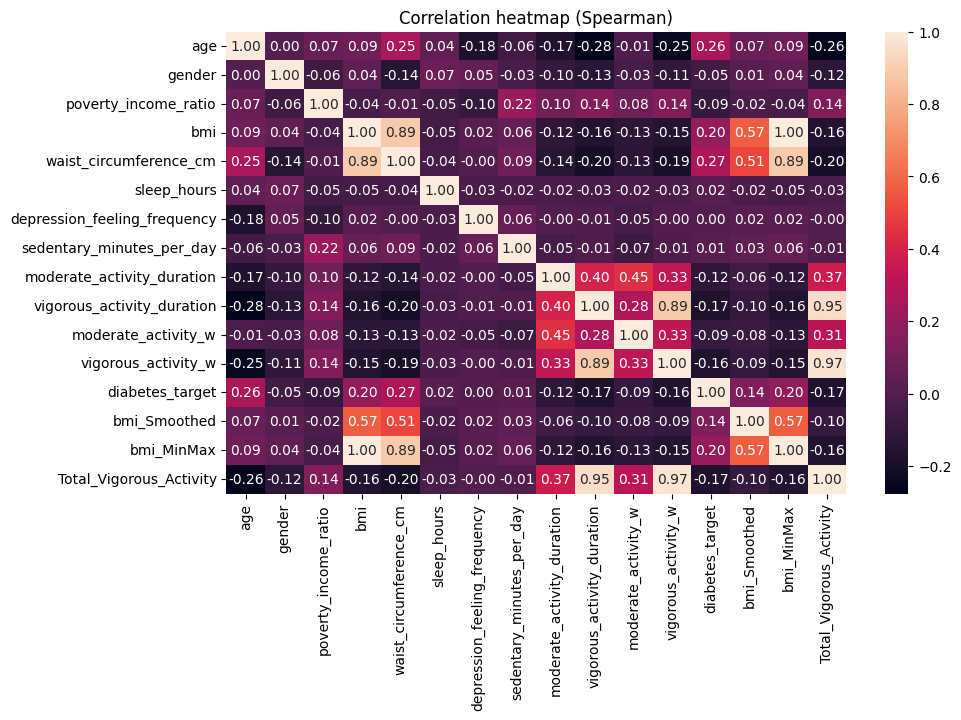

,age,gender,poverty_income_ratio,bmi,waist_circumference_cm,sleep_hours,depression_feeling_frequency,sedentary_minutes_per_day,moderate_activity_duration,vigorous_activity_duration,moderate_activity_w,vigorous_activity_w,diabetes_target,bmi_Smoothed,bmi_MinMax,Total_Vigorous_Activity
age,1.000000,0.003191,0.069633,0.086403,0.252328,0.040120,-0.180124,-0.055841,-0.166595,-0.276089,-0.014048,-0.246776,0.257450,0.066922,0.086403,-0.261988
gender,0.003191,1.000000,-0.063296,0.040831,-0.142580,0.073314,0.046863,-0.028645,-0.100071,-0.131879,-0.034548,-0.109017,-0.048028,0.014130,0.040831,-0.122649
poverty_income_ratio,0.069633,-0.063296,1.000000,-0.037616,-0.011435,-0.046841,-0.100678,0.216245,0.097386,0.140099,0.082922,0.137869,-0.087445,-0.019240,-0.037616,0.138800
bmi,0.086403,0.040831,-0.037616,1.000000,0.889313,-0.045732,0.020477,0.057061,-0.115996,-0.159855,-0.126105,-0.154761,0.201448,0.567773,1.000000,-0.159758
waist_circumference_cm,0.252328,-0.142580,-0.011435,0.889313,1.000000,-0.040209,-0.004076,0.087062,-0.143679,-0.202948,-0.127682,-0.192645,0.271079,0.510258,0.889313,-0.199777
sleep_hours,0.040120,0.073314,-0.046841,-0.045732,-0.040209,1.000000,-0.026840,-0.017646,-0.022060,-0.033652,-0.017637,-0.025132,0.015760,-0.019550,-0.045732,-0.028430
depression_feeling_frequency,-0.180124,0.046863,-0.100678,0.020477,-0.004076,-0.026840,1.000000,0.059391,-0.002527,-0.009419,-0.045530,-0.000637,0.000327,0.016017,0.020477,-0.004741
sedentary_minutes_per_day,-0.055841,-0.028645,0.216245,0.057061,0.087062,-0.017646,0.059391,1.000000,-0.046787,-0.007524,-0.068605,-0.013408,0.013710,0.033733,0.057061,-0.010673
moderate_activity_duration,-0.166595,-0.100071,0.097386,-0.115996,-0.143679,-0.022060,-0.002527,-0.046787,1.000000,0.401390,0.445360,0.331619,-0.118364,-0.061694,-0.115996,0.366901
vigorous_activity_duration,-0.276089,-0.131879,0.140099,-0.159855,-0.202948,-0.033652,-0.009419,-0.007524,0.401390,1.000000,0.281949,0.886608,-0.172806,-0.095086,-0.159855,0.951933


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reload df_final to ensure 'age', 'bmi', and other columns are numerical for correlation calculation
output_path = "/content/drive/MyDrive/WIA1007_Project/cleaned_diabetes.csv"
df_final = pd.read_csv(output_path)

# Correlation matrix (Spearman)
corr = df_final.corr(method = 'spearman', numeric_only=True)

# Creates a figure and draws a heatmap of the correlation matrix.
# annot=True prints the correlation values inside each cell.
# fmt=".2f" shows values with 2 decimal places.
# The heatmap makes it easy to spot strong relationships quickly.
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation heatmap (Spearman)")
plt.show()

# Displays the correlation matrix as a table as well (useful if you want exact values or to copy them).
corr

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats # Import scipy.stats for pearsonr

# Reload df_final to ensure numeric columns for correlation (as it might have been binned previously)
output_path = "/content/drive/MyDrive/WIA1007_Project/cleaned_diabetes.csv"
df_final = pd.read_csv(output_path)

# Correlation + p-value for a specific pair
def corr_with_pvalue(x, y):
    d = pd.DataFrame({"x": x, "y": y}).dropna() # Builds a temporary table with both columns and removes rows where either x or y is missing. Correlation requires pairs of values

    # If fewer than 3 valid pairs remain, correlation is unreliable/undefined → return NaN
    if len(d) < 3:
        return np.nan, np.nan, len(d)
    r, p = stats.pearsonr(d["x"], d["y"])
    return r, p, len(d)

# This list defines the relationships we want to test with the diabetes target
pairs = [
    ("age", "diabetes_target"),
    ("bmi", "diabetes_target"),
    ("waist_circumference_cm", "diabetes_target"),
    ("poverty_income_ratio", "diabetes_target"),
    ("sleep_hours", "diabetes_target"),
    ("sedentary_minutes_per_day", "diabetes_target"),
    ("moderate_activity_duration", "diabetes_target"),
    ("vigorous_activity_duration", "diabetes_target"),
    ("Total_Vigorous_Activity", "diabetes_target")
]

print("Pearson Correlation with p-value and valid sample count:")
for a, b in pairs:
    # Check if both columns exist in df_final before attempting correlation
    if a in df_final.columns and b in df_final.columns:
        r, p, n = corr_with_pvalue(df_final[a], df_final[b]) # Use df_final instead of df
        print(f"{a} vs {b}: r={r:.3f}, p={p:.3e}, n={n}")
    else:
        print(f"Warning: One or both columns '{a}' or '{b}' not found in DataFrame.")

Pearson Correlation with p-value and valid sample count:
age vs diabetes_target: r=0.261, p=2.767e-81, n=5178
bmi vs diabetes_target: r=0.199, p=1.292e-47, n=5178
waist_circumference_cm vs diabetes_target: r=0.275, p=1.218e-90, n=5178
poverty_income_ratio vs diabetes_target: r=-0.087, p=4.212e-10, n=5178
sleep_hours vs diabetes_target: r=0.020, p=1.510e-01, n=5178
sedentary_minutes_per_day vs diabetes_target: r=0.012, p=3.930e-01, n=5178
moderate_activity_duration vs diabetes_target: r=-0.101, p=3.175e-13, n=5178
vigorous_activity_duration vs diabetes_target: r=-0.121, p=3.053e-18, n=5178
Total_Vigorous_Activity vs diabetes_target: r=-0.065, p=2.436e-06, n=5178


How to interpret the output:

* r tells direction and strength:

* r = +0.40 → moderate positive association

* r = -0.30 → moderate negative association

* r ≈ 0 → no linear association

p-value tells whether the observed correlation is unlikely under “no relationship”:

* p < 0.05 → statistically significant evidence correlation ≠ 0

* p ≥ 0.05 → not enough evidence (could still be a weak relationship or too little data)

n matters because:

* large n can make small correlations significant

* small n makes results unstable

/tmp/ipython-input-3498871917.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age', y='diabetes_target', data=df_final, palette='Blues', errorbar=None)
/tmp/ipython-input-3498871917.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bmi', y='diabetes_target', data=df_final, palette='Reds', errorbar=None)
/tmp/ipython-input-3498871917.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sleep_hours', y='diabetes_target', data=df_final, palette='Purples', errorbar=None)


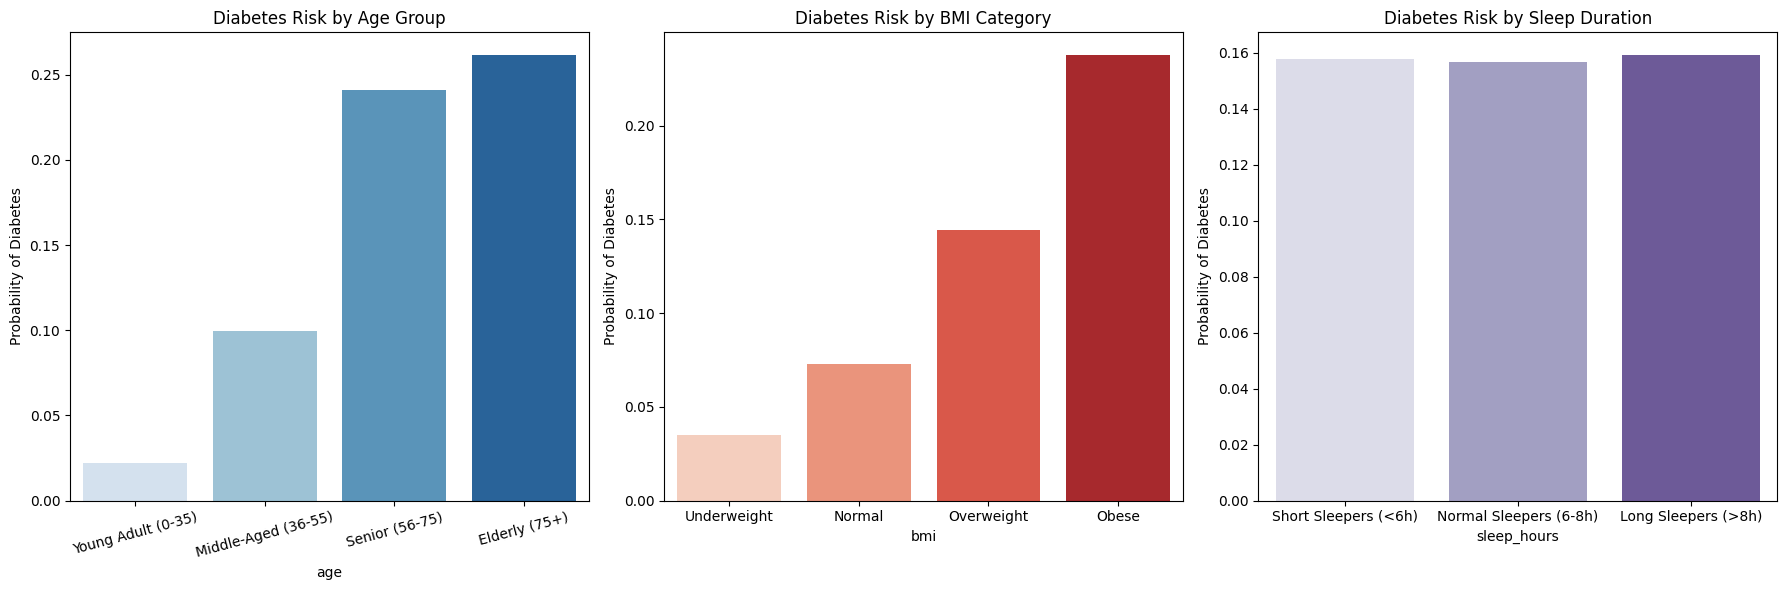

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Age Binning ---
# Logic: Life stages (Young, Middle, Senior, Elderly)
age_bins = [0, 35, 55, 75, 120]
age_labels = ['Young Adult (0-35)', 'Middle-Aged (36-55)', 'Senior (56-75)', 'Elderly (75+)']
df_final['age'] = pd.cut(df_final['age'], bins=age_bins, labels=age_labels, right=False)

# --- 2. BMI Binning ---
# Logic: Standard Medical Categories (Underweight, Normal, Overweight, Obese)
bmi_bins = [0, 18.5, 25, 30, 100]
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
df_final['bmi'] = pd.cut(df_final['bmi'], bins=bmi_bins, labels=bmi_labels, right=False)

# --- 3. Sleep Binning ---
# Logic: Check for extremes (Too little vs. Too much)
sleep_bins = [0, 6, 8, 24]
sleep_labels = ['Short Sleepers (<6h)', 'Normal Sleepers (6-8h)', 'Long Sleepers (>8h)']
df_final['sleep_hours'] = pd.cut(df_final['sleep_hours'], bins=sleep_bins, labels=sleep_labels, right=False)

plt.figure(figsize=(18, 6))

# Plot 1: Age Risk
plt.subplot(1, 3, 1)
sns.barplot(x='age', y='diabetes_target', data=df_final, palette='Blues', errorbar=None)
plt.title('Diabetes Risk by Age Group')
plt.ylabel('Probability of Diabetes')
plt.xticks(rotation=15)

# Plot 2: BMI Risk
plt.subplot(1, 3, 2)
sns.barplot(x='bmi', y='diabetes_target', data=df_final, palette='Reds', errorbar=None)
plt.title('Diabetes Risk by BMI Category')
plt.ylabel('Probability of Diabetes')

# Plot 3: Sleep Risk
plt.subplot(1, 3, 3)
sns.barplot(x='sleep_hours', y='diabetes_target', data=df_final, palette='Purples', errorbar=None)
plt.title('Diabetes Risk by Sleep Duration')
plt.ylabel('Probability of Diabetes')

plt.tight_layout()
plt.show() # Remove this line if saving to file instead
plt.savefig('binning_analysis_full.png')

Scatter plot

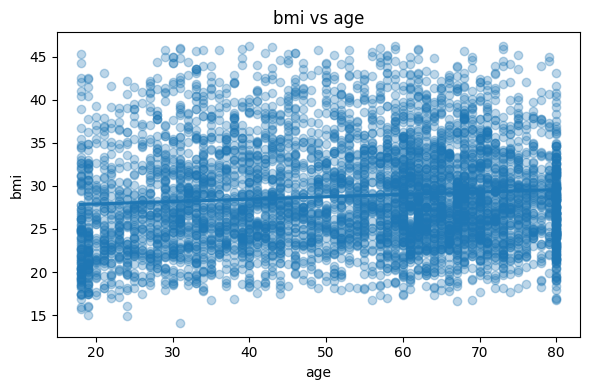

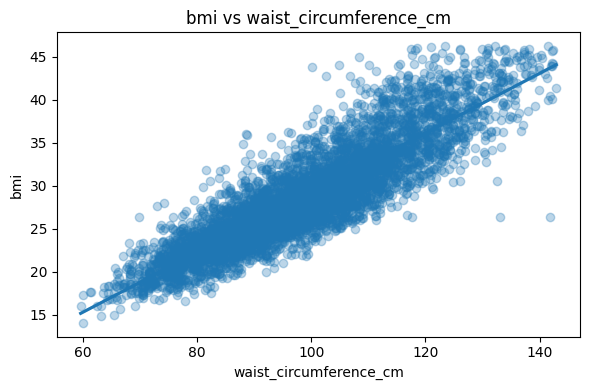

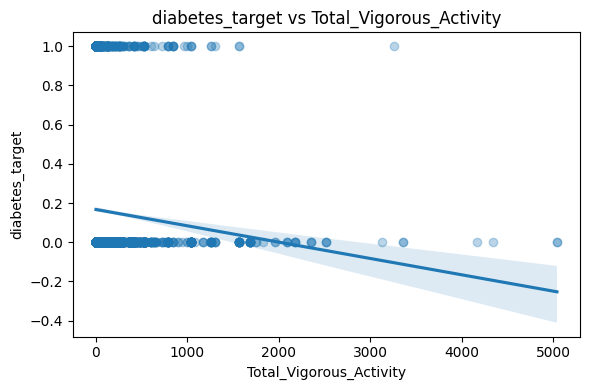

In [ ]:
def scatter_with_line(x_col, y_col, data):
    d = data[[x_col, y_col]].dropna() # Removes rows where either value is missing (NaN), so plotting and regression work cleanly
    plt.figure(figsize=(6, 4)) # Creates a new figure with a fixed size
    sns.regplot(x=x_col, y=y_col, data=d, scatter_kws={"alpha": 0.3}) # regplot draws: scatter points, a linear regression line (default), alpha=0.3 makes points semi-transparent so dense regions don’t become a dark blob

    # Makes the plot readable and displays it
    plt.title(f"{y_col} vs {x_col}")
    plt.tight_layout()
    plt.show()


# Reload df_final to ensure numeric columns are available for scatter plots
output_path = "/content/drive/MyDrive/WIA1007_Project/cleaned_diabetes.csv"
df_final_numerical = pd.read_csv(output_path)

# Add relevant scatter plots for the current df_final, for example:
if "age" in df_final_numerical.columns and "bmi" in df_final_numerical.columns:
    scatter_with_line("age", "bmi", data=df_final_numerical)

if "waist_circumference_cm" in df_final_numerical.columns and "bmi" in df_final_numerical.columns:
    scatter_with_line("waist_circumference_cm", "bmi", data=df_final_numerical)

if "Total_Vigorous_Activity" in df_final_numerical.columns and "diabetes_target" in df_final_numerical.columns:
    scatter_with_line("Total_Vigorous_Activity", "diabetes_target", data=df_final_numerical)

Two sample t-test

In [ ]:
# Prepare a clean subset for Gender t-test
# We'll compare gender 0 vs gender 1

# Prevents errors if the dataset doesn’t have those columns
if "gender" in df_final_numerical.columns and "bmi" in df_final_numerical.columns:
    df_tt = df_final_numerical[df_final_numerical["gender"].isin([0, 1])][["gender", "bmi"]].dropna() # Keep only the two groups + the needed columns, remove missing values

    # Split bmi into two separate groups based on gender
    g1 = df_tt[df_tt["gender"] == 0]["bmi"]
    g2 = df_tt[df_tt["gender"] == 1]["bmi"]

    # Print sample size and mean for each group (descriptive stats)
    print("n(Gender 0) =", len(g1), " mean =", g1.mean())
    print("n(Gender 1)   =", len(g2), " mean =", g2.mean())

    # Run Welch’s two-sample t-test
    t_stat, p_val = stats.ttest_ind(g1, g2, equal_var=False)
    # ttest_ind compares the means of two independent groups
    # equal_var=False means Welch’s t-test, which is safer because it does not assume equal variance between groups.

    # Output: t_stat = the test statistic.
    # p_val = probability of seeing a difference this large (or larger) if the true means were equal.
    print("Welch t-test: t =", t_stat, " p =", p_val)
else:
    print("Required columns missing: gender and/or bmi")

n(Gender 0) = 2307  mean = 28.389076723016906
n(Gender 1)   = 2871  mean = 29.120898641588298
Welch t-test: t = -4.429556065427299  p = 9.63762969694191e-06


**How to interpret the result**:

*   If p_val < 0.05: evidence that mean salary differs between Women and Men (statistically significant).

*   If p_val >= 0.05: not enough evidence to conclude a mean difference (based on this sample).

effect size

### Effect size (Cohen’s d)

P-value tells you if a difference is likely non-random.  
Effect size tells you **how big** the difference is.

This code is calculating Cohen’s d, which is an effect size for the difference between two groups (here: Women vs Men salaries).

*   A t-test tells you whether the means differ (significance).
*   Cohen’s d tells you how big that difference is (practical magnitude).

**How to interpret Cohen’s d (rule of thumb)**:

*   |d| ≈ 0.2 → small difference
*   |d| ≈ 0.5 → medium difference
*   |d| ≈ 0.8 → large difference

In [ ]:
def cohens_d(a, b):
    # Removes missing values from both groups so calculations are clean
    a = a.dropna()
    b = b.dropna()
    na, nb = len(a), len(b)

    # Checks sample sizes. If either group has fewer than 2 values, variance can’t be computed reliably → return NaN
    if na < 2 or nb < 2:
        return np.nan

    sa2 = a.var(ddof=1)
    sb2 = b.var(ddof=1)

    # Computes sample variances of each group (ddof=1 makes it sample variance)
    sp = np.sqrt(((na - 1)*sa2 + (nb - 1)*sb2) / (na + nb - 2))

    # Computes the pooled standard deviation sp. This is a weighted average of the two group variances (weighted by sample sizes), then square-rooted.
    return (a.mean() - b.mean()) / sp # Returns Cohen’s d: It measures the mean difference in standard deviation units.

# Assuming g1 and g2 are already defined from the previous t-test cell
# If they are not, you would need to define them here, e.g.,
# g1 = df_final[df_final["gender"] == 0]["bmi"].dropna()
# g2 = df_final[df_final["gender"] == 1]["bmi"].dropna()

# Ensure g1 and g2 are available from the previous execution
if 'g1' in locals() and 'g2' in locals():
    d = cohens_d(g1, g2)
    print("Cohen's d (BMI for Male vs Female):", d)
else:
    print("g1 and g2 (gender groups for BMI) are not defined. Please run the previous t-test cell first.")

Cohen's d (BMI for Male vs Female): -0.12142497340171345


# ANOVA

**What question are we trying to answer?**

Do people with different gender have different bmi ?

Groups used: [0. 1.]
ANOVA (bmi by diabetes_target): F = 214.46616801987184  p = 1.2920850178855458e-47


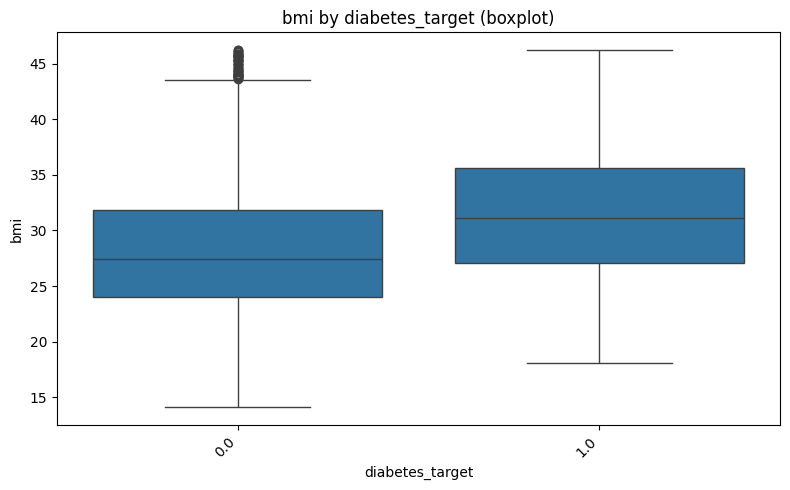

In [ ]:
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reload df_final to ensure numeric columns are available, as previous cells might have modified them
output_path = "/content/drive/MyDrive/WIA1007_Project/cleaned_diabetes.csv"
df_final = pd.read_csv(output_path)

# One-way ANOVA: BMI by Gender

# Define the categorical grouping column and the numerical dependent variable
group_col = "diabetes_target"
numerical_col = "bmi"

# Proceed only if required columns exist
if group_col in df_final.columns and numerical_col in df_final.columns:
    df_aov = df_final[[group_col, numerical_col]].dropna() # Selects only gender + bmi, removing rows with missing values

    # Ensure gender values are appropriate for grouping (0 and 1 from previous steps)
    df_aov = df_aov[df_aov[group_col].isin([0, 1])]

    # Get unique groups from the filtered data
    groups_in_data = df_aov[group_col].unique()

    # Build a list of BMI values for each gender group
    groups = [df_aov[df_aov[group_col] == g][numerical_col] for g in groups_in_data]

    # Filter out groups with fewer than 2 samples (f_oneway requires at least two samples per group)
    groups = [g for g in groups if len(g) >= 2]

    if len(groups) < 2:
        print(f"Not enough groups with sufficient data for ANOVA for {numerical_col} by {group_col}.")
    else:
        # Computes ANOVA F-statistic and p-value
        f_stat, p_val = stats.f_oneway(*groups)
        print("Groups used:", groups_in_data)
        print(f"ANOVA ({numerical_col} by {group_col}): F =", f_stat, " p =", p_val)

        # Visual: boxplot to show distribution per group
        plt.figure(figsize=(8, 5))
        sns.boxplot(data=df_aov, x=group_col, y=numerical_col)
        plt.title(f"{numerical_col} by {group_col} (boxplot)")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
else:
    print(f"Required columns missing: {group_col} and/or {numerical_col}")

# Linear Regression (bivariate + simple multivariate extension)

                            OLS Regression Results                            
Dep. Variable:                    bmi   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     214.5
Date:                Sat, 10 Jan 2026   Prob (F-statistic):           1.29e-47
Time:                        08:09:49   Log-Likelihood:                -16552.
No. Observations:                5178   AIC:                         3.311e+04
Df Residuals:                    5176   BIC:                         3.312e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              28.2729      0.090    3

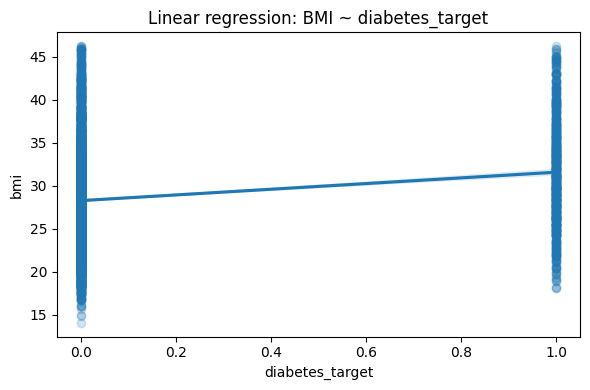

In [ ]:
# Simple linear regression with statsmodels. Uses statsmodels because it gives interpretable statistical output.
try:
    import statsmodels.api as sm
    import pandas as pd

    # Reload df_final_numerical to ensure it has numeric columns before regression
    output_path = "/content/drive/My Drive/WIA1007_Project/cleaned_diabetes.csv"
    df_final_numerical = pd.read_csv(output_path)

    if "bmi" in df_final_numerical.columns and "diabetes_target" in df_final_numerical.columns: # Runs only if both required columns exist.
        d = df_final_numerical[["bmi", "diabetes_target"]].dropna() # Keeps only those two columns and removes missing rows. Regression cannot be fit with NaNs.
        X = sm.add_constant(d["diabetes_target"]) # Creates the predictor matrix X (age) and Y (bmi).
        y = d["bmi"]
        model = sm.OLS(y, X).fit() # Target variable (what we are predicting).
        print(model.summary()) # Prints a detailed report including: coef (intercept and slope), p-values (is the slope significantly different from 0?), R-squared (how much variance in salary the model explains), confidence intervals, etc.

        # Plot line
        plt.figure(figsize=(6,4))
        # Draws: scatter points (bmi vs age), the fitted regression line, alpha=0.2 makes points transparent so dense areas don’t hide patterns.
        sns.regplot(x="diabetes_target", y="bmi", data=d, scatter_kws={"alpha":0.2})
        plt.title("Linear regression: BMI ~ diabetes_target")
        plt.tight_layout()
        plt.show()
    else:
        print("Missing bmi and/or diabetes-target for regression.")
except Exception as e:
    print("Regression skipped:", e)


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.linear_model import LinearRegression

output_path = "/content/drive/My Drive/WIA1007_Project/cleaned_diabetes.csv"
df_final_numerical = pd.read_csv(output_path)

# ---------------------------------------------------------
# STEP 1: CREATE THE BINS (Text Labels)
# ---------------------------------------------------------
# We artificially create these text bins because your midpoint function expects them.
age_bins = [0, 35, 55, 75, 120]
age_labels = ['Young Adult (0-35)', 'Middle-Aged (36-55)', 'Senior (56-75)', 'Elderly (75+)']

# Create the categorical column (e.g., "Middle-Aged (36-55)")
df_final_numerical['Age_Life_Stage'] = pd.cut(df_final_numerical['age'], bins=age_bins, labels=age_labels, right=False)

# ---------------------------------------------------------
# STEP 2: DEFINE THE PARSING FUNCTION
# ---------------------------------------------------------
def midpoint_from_bin(text):
    """
    Parses text like 'Young Adult (0-35)' and returns the numeric midpoint (17.5).
    """
    if pd.isna(text):
        return np.nan

    s = str(text).strip().lower()

    # regex: find all numbers (integers or decimals) inside the string
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", s)
    numbers = [float(n) for n in numbers]

    # Logic: Average the two numbers found
    if len(numbers) >= 2:
        return (numbers[0] + numbers[1]) / 2.0

    # Logic: Handle single number cases (e.g. "75+")
    elif len(numbers) == 1:
        if "+" in s or "over" in s:
            return numbers[0] + 5.0 # Estimate
        return numbers[0]

    return np.nan

# ---------------------------------------------------------
# STEP 3: APPLY FUNCTION TO GET NUMERIC MIDPOINTS
# ---------------------------------------------------------
# This creates the 'Age_Midpoint' column which is REQUIRED for Linear Regression
df_final_numerical['Age_Midpoint'] = df_final_numerical['Age_Life_Stage'].apply(midpoint_from_bin)

# Check the data to ensure we have numbers
print("Data Preparation Check:")
print(df_final_numerical[['age', 'Age_Life_Stage', 'Age_Midpoint']].head())

# ---------------------------------------------------------
# STEP 4: LINEAR REGRESSION
# ---------------------------------------------------------
# Now that we have a numeric 'Age_Midpoint' column, we can run regression.

# A. Prepare the inputs
X = df_final_numerical[['Age_Midpoint']]  # The Independent Variable (Must be 2D array for sklearn)
y = df_final_numerical['diabetes_target'] # The Dependent Variable (Target)

# B. Create and Train the Model
model = LinearRegression()
model.fit(X, y)

# C. View the Results
slope = model.coef_[0]
intercept = model.intercept_

print("\n--- Linear Regression Results ---")
print(f"Slope (Coefficient): {slope:.5f}")
print(f"Intercept: {intercept:.5f}")
print(f"Equation: Risk = {slope:.5f} * Age_Midpoint + {intercept:.5f}")
print("Interpretation: For every 1 year increase in estimated age, diabetes risk increases by {:.2f}%".format(slope * 100))

Data Preparation Check:
    age       Age_Life_Stage Age_Midpoint
0  43.0  Middle-Aged (36-55)         45.5
1  66.0       Senior (56-75)         65.5
2  44.0  Middle-Aged (36-55)         45.5
3  34.0   Young Adult (0-35)         17.5
4  59.0       Senior (56-75)         65.5

--- Linear Regression Results ---
Slope (Coefficient): 0.00442
Intercept: -0.06831
Equation: Risk = 0.00442 * Age_Midpoint + -0.06831
Interpretation: For every 1 year increase in estimated age, diabetes risk increases by 0.44%


# 3 Feature Selection

## 3.1 Ask questions
* Which non-invasive demographic and physiological markers demonstrate the strongest statistical association with diabetes prevalence in the CDC dataset?
* Can we develop a binary classification model (Logistic Regression/Random Forest) to predict diabetes risk with an F1-score exceeding 0.44, utilizing only easily obtainable patient information?
* Based on the model's coefficients, to what extent does socioeconomic status (PIR) mitigate the risk of diabetes compared to physiological factors like waist circumference?

## 3.2 Select varibles

According to the result of EDA, we preserve all the columns except `sleep_hours`, `depression_feeling_frequency` and `sedentary_minutes_per_day` for they are little relevant to our target variable.

Furthermore, we should also drop `bmi` because it is highly related to waist circum, placing potential unstability under the model.
## 3.3 Reduction
Replace frequency and duration by their multiplication to reduce the unstability.

In [ ]:
# Drop columns unselected
df_ml = df_final.drop(columns = ['sleep_hours','depression_feeling_frequency','sedentary_minutes_per_day','bmi','bmi_Smoothed','bmi_MinMax'])

In [ ]:
df_ml['moderate_activity_m_w'] = df_ml['moderate_activity_duration'] * df_ml['moderate_activity_w']
df_ml['vigorous_activity_m_w'] = df_ml['vigorous_activity_duration'] * df_ml['vigorous_activity_w']

df_ml = df_ml.drop(columns = ['moderate_activity_duration','moderate_activity_w','vigorous_activity_duration','vigorous_activity_w'])

It is not clear for how to distinguish "moderate" and "vigorous". And their correlations on diabetes are similar. Merge the two kinds of activity together.

In [ ]:
df_ml["activity_level"] = df_ml["moderate_activity_m_w"] + df_ml["vigorous_activity_m_w"]

df_ml = df_ml.drop(columns = ['moderate_activity_m_w','vigorous_activity_m_w'])

In [ ]:
df_ml = df_ml.drop(columns = ['Total_Vigorous_Activity'])

Save the data features for future usage.

In [ ]:
file_path_ml_feature = base_path + 'ml_feature.csv'
df_ml.describe().to_csv(file_path_ml_feature, index=False)

# 4 Model Training

In [ ]:
df_ml.describe()

,age,gender,poverty_income_ratio,waist_circumference_cm,diabetes_target,activity_level
count,5178.000000,5178.000000,5178.000000,5178.000000,5178.000000,5178.000000
mean,52.296640,0.554461,2.933490,98.869003,0.158169,322.299667
std,18.150841,0.497073,1.553687,15.391579,0.364935,459.260624
min,18.000000,0.000000,0.000000,59.600000,0.000000,0.000000
25%,37.000000,0.000000,1.710000,87.500000,0.000000,60.000000
50%,56.000000,1.000000,2.500000,98.300000,0.000000,190.350000
75%,67.000000,1.000000,4.795000,109.500000,0.000000,420.000000
max,80.000000,1.000000,5.000000,142.900000,1.000000,6720.000000


## 4.1 Model Selection

We have already know the target variable in our dataset
----- Supervised ML

The target variable is binary or categorized
----- No linear regression; choose Logistic Regression, Random Foresst and Decision Tree

## 4.2 Stratification

In [ ]:
from sklearn.model_selection import train_test_split

X = df_ml.drop(columns=['diabetes_target'])
y = df_ml['diabetes_target']

# Split test set
# stratify=y make sure all the group has a percentage 15% of diabetics;
# Or it may probably generate a group with little diabetic proportion
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42, # Random seed = 42
    stratify=y
)

# Split validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.1765, # 0.1765 * 0.85 = 0.15
    random_state=42,
    stratify=y_temp
)

## Train : Validate : Test = 70 : 15 : 15

## 4.3 Normalization

We apply z-score to the process of standardization.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Drop the non-numeric 'Age Category' column from X_train, X_val, X_test if it exists
# This ensures that only numerical data is passed to the scaler.
if 'Age Category' in X_train.columns:
    X_train = X_train.drop(columns=['Age Category'])
if 'Age Category' in X_val.columns:
    X_val = X_val.drop(columns=['Age Category'])
if 'Age Category' in X_test.columns:
    X_test = X_test.drop(columns=['Age Category'])

# Get scaled set
X_train_scaled = scaler.fit_transform(X_train)

# Transform validation set with std and mean got from train set
X_val_scaled = scaler.transform(X_val)

# Do the same to test set
X_test_scaled = scaler.transform(X_test)

## 4.4 Baseline Comparison
* Logistic Regression
* Decision Tree
* Random Forest

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score

# Initialize models

models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

results = []

for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)

    acc = accuracy_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Recall": rec,
        "F1-Score": f1
    })

results_df = pd.DataFrame(results)

print('=======Baseline Comparison======')
print(results_df.round(4))

=======Baseline Comparison======
                 Model  Accuracy  Recall  F1-Score
0  Logistic Regression    0.8443  0.1057    0.1769
1        Decision Tree    0.7568  0.2764    0.2646
2        Random Forest    0.8314  0.0894    0.1438


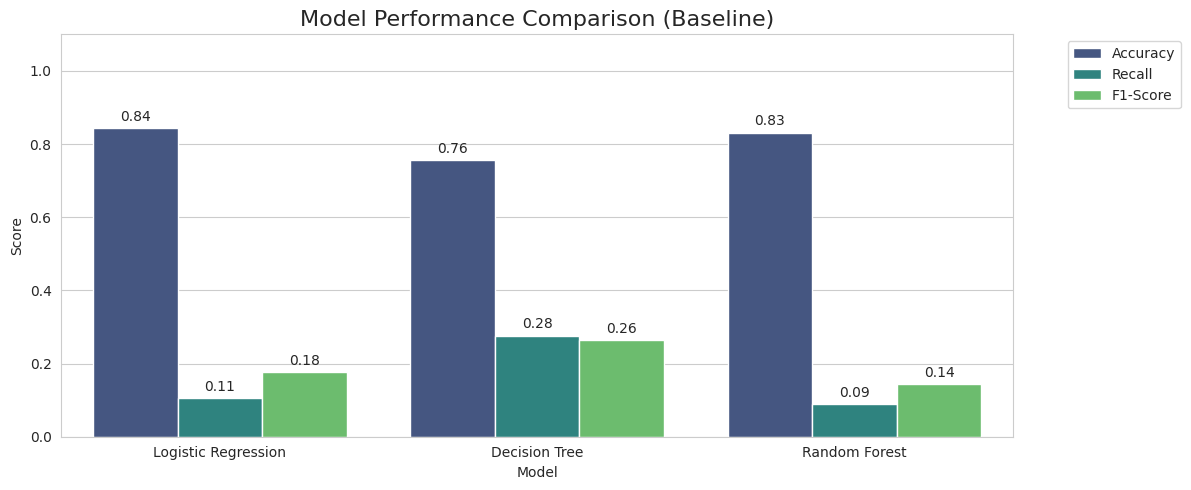

In [ ]:
plt.figure(figsize=(12,5))
sns.set_style("whitegrid")

chart = sns.barplot(data=results_df.melt(id_vars="Model", var_name="Metric", value_name="Score"), x="Model", y="Score", hue="Metric", palette="viridis")

for container in chart.containers:
    chart.bar_label(container, fmt='%.2f', padding=3)

plt.title("Model Performance Comparison (Baseline)", fontsize=16)
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # legend

plt.tight_layout()
plt.show()

We notice that all the models have high accurancy but low recall and low F1-score. To explain this, we can turn back to our dataset.

In [ ]:
df_final['diabetes_target'].describe()

,diabetes_target
count,5178.000000
mean,0.158169
std,0.364935
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


`Diabetes_target` has binary values: 0 and 1, the mean = 0.158 shows that we only have 15.8% diabetics but 84.2% non-diabetics.  
Therefore, to achieve a high accuracy, the model tend to predict all the subjects as healthy. By doing that, we can achieve an accuracy of 84.2% while it is meaningless. In practice, we can easily re-examine a patient to eliminate a fake postive, but it will be hard to deal with if there is a high rate of fake negative.  

To value the `Recall` = $\frac{TP}{TP+FN}$, we will order all the 3 models as class_weight = 'balanced', and train the models again.

In [ ]:
# Initialize models

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced',random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced',random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced',random_state=42)
}

results = []

for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)

    acc = accuracy_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Recall": rec,
        "F1-Score": f1
    })

results_df = pd.DataFrame(results)

print('=======Baseline Comparison======')
print(results_df.round(4))

=======Baseline Comparison======
                 Model  Accuracy  Recall  F1-Score
0  Logistic Regression    0.7066  0.7236    0.4384
1        Decision Tree    0.7671  0.2358    0.2427
2        Random Forest    0.8353  0.0732    0.1233


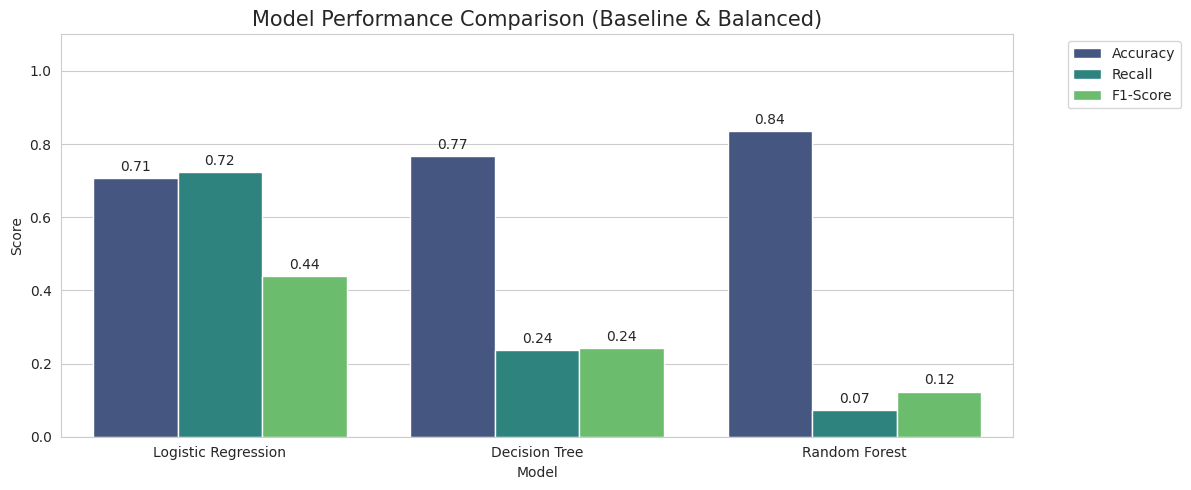

In [ ]:
plt.figure(figsize=(12,5))
sns.set_style("whitegrid")

chart = sns.barplot(data=results_df.melt(id_vars="Model", var_name="Metric", value_name="Score"), x="Model", y="Score", hue="Metric", palette="viridis")

for container in chart.containers:
    chart.bar_label(container, fmt='%.2f', padding=3)

plt.title("Model Performance Comparison (Baseline & Balanced)", fontsize=15)
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # legend

plt.tight_layout()
plt.show()

It is clear that Logistic Regression beat the other two models on diabetic prediction. By making the regression penalty weighted, logistic regression become significantly valuing patients. With a decrement in accuracy from 0.84 to 0.71, the recall surges from 0.11 to 0.72, while the other two "rebellious" models' recall become even lower.  

It is worthy reflection that a logically simpler model perform much better than its more complex peers.

## 4.5 Fine-Tuning

As we have found out that the best model is Logistic Regression, here we further tune-fine the model to explore if we can achieve even better performance.

The parameter in Logistic Regression model is `c`, which represents the reciprocal of the coefficient of regularization. With smaller `c`, the sum of all the square/absolution value of coefficients will be limited to a small amount, resulting in an underfitting; with larger `c`, the condition is opposite -- overfitting.

Here we change `c` to see where the Logistic Regression model performs best.

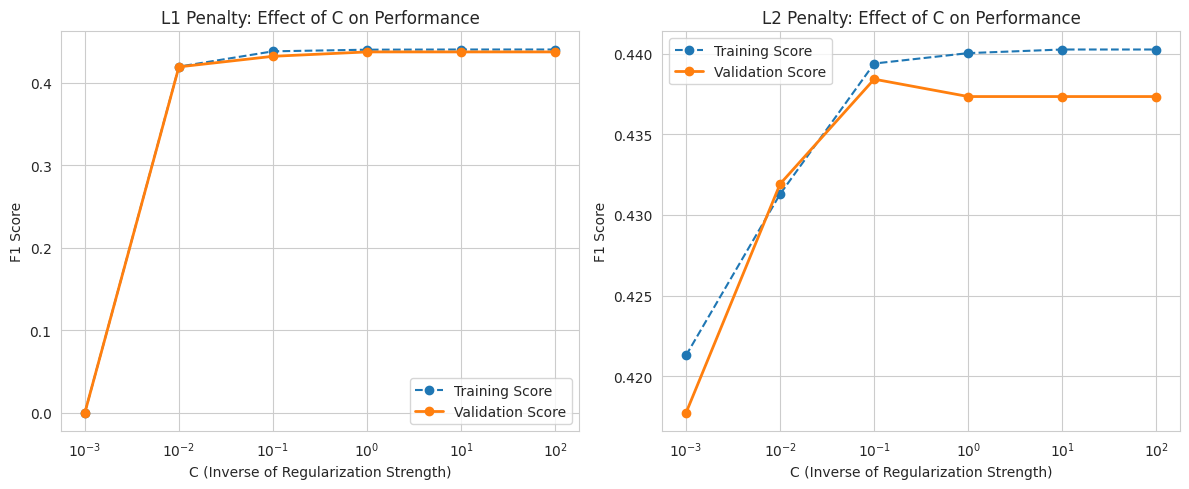

In [ ]:
c_values = [0.001, 0.01, 0.1, 1, 10, 100]
penalty_patterns = ['l1','l2']

results = []

for p in penalty_patterns:
    for c in c_values:
        model = LogisticRegression(penalty=p, C=c, class_weight='balanced', solver = 'liblinear', random_state=42)
        model.fit(X_train_scaled, y_train)

        # Predict on training model to see if there is an overfitting
        y_train_pred = model.predict(X_train_scaled)
        y_val_pred = model.predict(X_val_scaled)

        # save F1 score
        train_score = f1_score(y_train, y_train_pred)
        val_score = f1_score(y_val, y_val_pred)

        # save data together
        results.append({
            'Penalty': p,
            'C': c,
            'Train_Score': train_score,
            'Val_Score': val_score
        })

df_results = pd.DataFrame(results)

plt.figure(figsize=(12, 5))

# subplot for model L1 (absolute)
plt.subplot(1, 2, 1)
data_l1 = df_results[df_results['Penalty'] == 'l1']
plt.plot(data_l1['C'], data_l1['Train_Score'], marker='o', label='Training Score', linestyle='--')
plt.plot(data_l1['C'], data_l1['Val_Score'], marker='o', label='Validation Score', linewidth=2)
plt.xscale('log')
plt.title('L1 Penalty: Effect of C on Performance')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

# subplot for model L2 (square)
plt.subplot(1, 2, 2)
data_l2 = df_results[df_results['Penalty'] == 'l2']
plt.plot(data_l2['C'], data_l2['Train_Score'], marker='o', label='Training Score', linestyle='--')
plt.plot(data_l2['C'], data_l2['Val_Score'], marker='o', label='Validation Score', linewidth=2)
plt.xscale('log')
plt.title('L2 Penalty: Effect of C on Performance')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

The scale of vertical axis differ a lot among two penalty patterns. We focusing on the performance of two patterns around $c=0.1$ to see the behavior of these two curves more clearly.

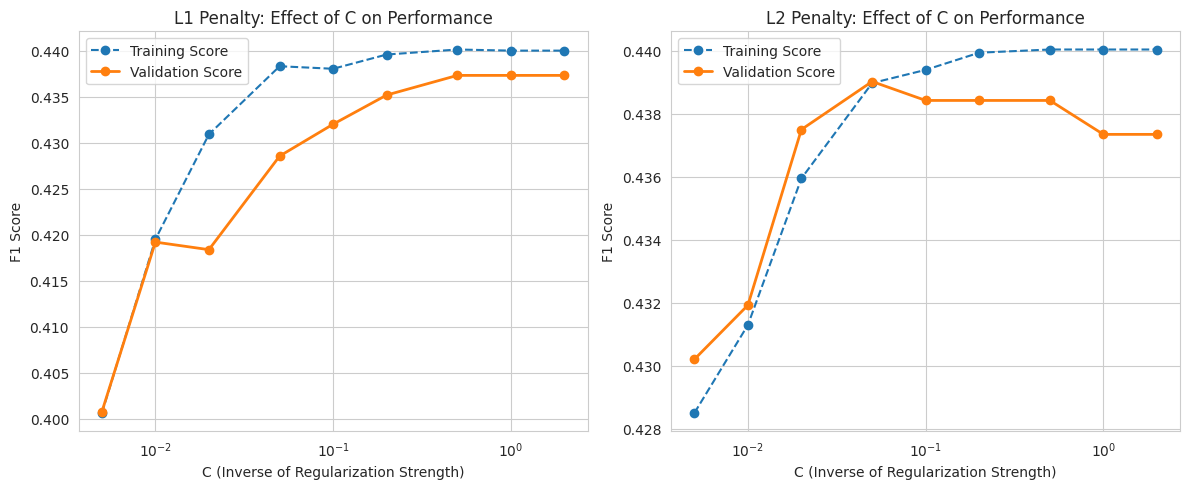

In [ ]:
c_values = [0.005 ,0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2]
penalty_patterns = ['l1','l2']

results = []

for p in penalty_patterns:
    for c in c_values:
        model = LogisticRegression(penalty=p, C=c, class_weight='balanced', solver = 'liblinear', random_state=42)
        model.fit(X_train_scaled, y_train)

        # Predict on training model to see if there is an overfitting
        y_train_pred = model.predict(X_train_scaled)
        y_val_pred = model.predict(X_val_scaled)

        # save F1 score
        train_score = f1_score(y_train, y_train_pred)
        val_score = f1_score(y_val, y_val_pred)

        # save data together
        results.append({
            'Penalty': p,
            'C': c,
            'Train_Score': train_score,
            'Val_Score': val_score
        })

df_results = pd.DataFrame(results)

plt.figure(figsize=(12, 5))

# subplot for model L1 (absolute)
plt.subplot(1, 2, 1)
data_l1 = df_results[df_results['Penalty'] == 'l1']
plt.plot(data_l1['C'], data_l1['Train_Score'], marker='o', label='Training Score', linestyle='--')
plt.plot(data_l1['C'], data_l1['Val_Score'], marker='o', label='Validation Score', linewidth=2)
plt.xscale('log')
plt.title('L1 Penalty: Effect of C on Performance')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

# subplot for model L2 (square)
plt.subplot(1, 2, 2)
data_l2 = df_results[df_results['Penalty'] == 'l2']
plt.plot(data_l2['C'], data_l2['Train_Score'], marker='o', label='Training Score', linestyle='--')
plt.plot(data_l2['C'], data_l2['Val_Score'], marker='o', label='Validation Score', linewidth=2)
plt.xscale('log')
plt.title('L2 Penalty: Effect of C on Performance')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Considering the smaller scale of axis y in the graph of L2, two patterns shows similar fluctuation. But L2's validation performance fit that of its training better. Therefore, we take `L2` as a better penalty pattern.

As for `c`, we choose `c=0.05` as the best which is the inflection point. It is where the curve goes gentle after a steep incline, which means it balances the overfitting and underfitting.

In [ ]:
penalty_best = 'l2'
C_best = 0.05

In [ ]:
feature_names = X_train.columns.tolist()

best_model = LogisticRegression(C = C_best, penalty= penalty_best, random_state=42, class_weight = 'balanced', solver='liblinear')
best_model.fit(X_train_scaled, y_train)

coefs = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': best_model.coef_[0]
})

print(coefs)

                  Feature  Coefficient
0                     age     0.857793
1                  gender    -0.104695
2    poverty_income_ratio    -0.319180
3  waist_circumference_cm     0.750378
4          activity_level    -0.074648


# 5 Evaluation
This part we walk our model through the test set to assess its final performance and lead to our conclusion.

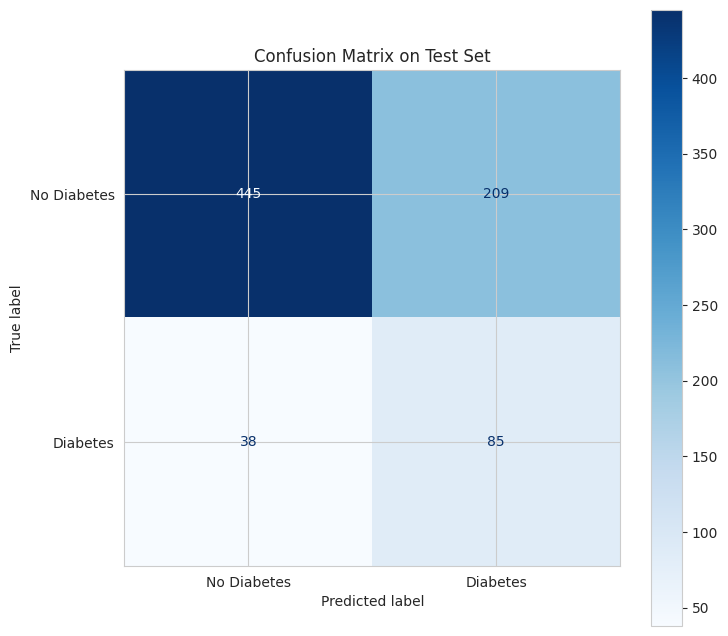

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model = LogisticRegression(C = C_best, penalty= penalty_best, random_state=42, class_weight = 'balanced', solver='liblinear')
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])


fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Confusion Matrix on Test Set')
plt.show()

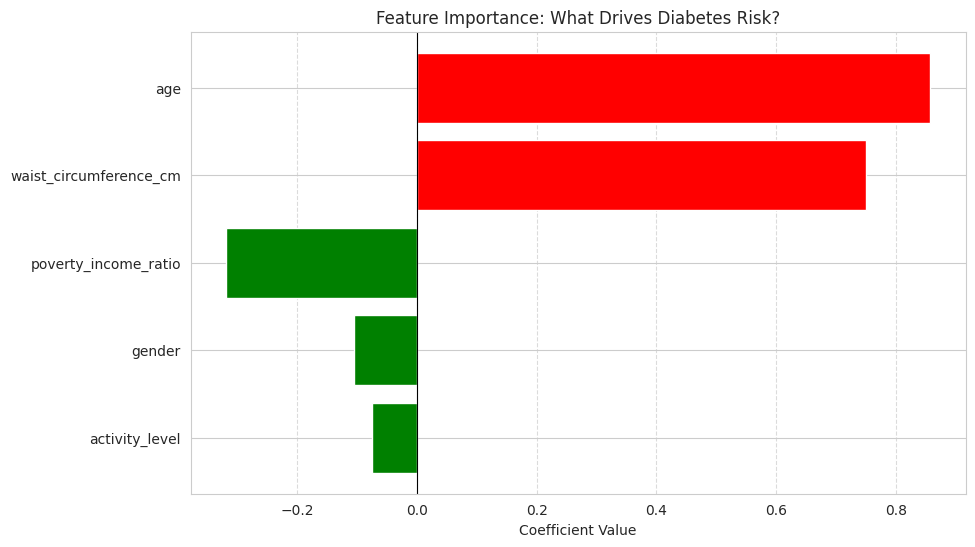

In [ ]:
# Sort the coefficients with abs
coefs = coefs.reindex(coefs['Coefficient'].abs().sort_values(ascending=True).index)

# Red for Pathogenic  Green for Diease-resistant   Factors
colors = ['red' if c > 0 else 'green' for c in coefs['Coefficient']]

plt.figure(figsize=(10, 6))
plt.barh(coefs['Feature'], coefs['Coefficient'], color=colors)
plt.title('Feature Importance: What Drives Diabetes Risk?')
plt.xlabel('Coefficient Value')
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Counterfactual Simulation

Selected Patient Index: 88
Profile: Age 49, Waist 139.8 cm
Initial Predicted Risk: 87.86%
Simulation Result: Losing 10cm reduces risk from 87.86% to 81.68%


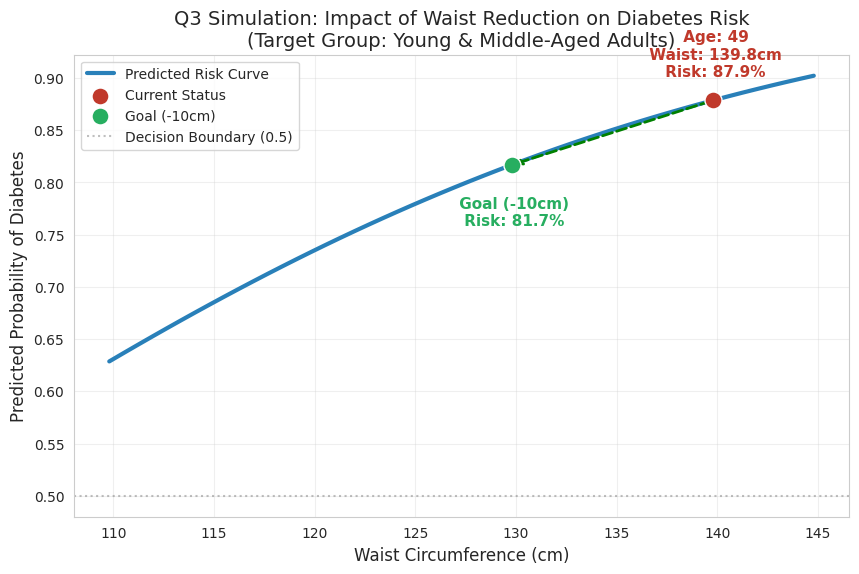

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_waist_simulation_younger(model, scaler, X_original, feature_names):
    """
    Q3 Refined: Waist Circumference Intervention Simulation
    Target Group: Young and Middle-Aged Adults (Age < 60)

    This function isolates a high-risk patient within the target age group
    and simulates the effect of waist reduction on their diabetes risk.
    """

    # 1. Predict probabilities for the entire dataset
    # We need to find a candidate who is High Risk AND Young/Middle-Aged
    X_scaled_all = scaler.transform(X_original)
    probs_all = model.predict_proba(X_scaled_all)[:, 1]

    # 2. Define Filters
    # Criterion 1: High Risk (Probability > 0.5)
    # Criterion 2: Target Age Group (18 <= Age < 60)
    # Criterion 3: Waist Circumference is large enough to be reduced (> 90cm)

    age_col = 'age'
    waist_col = 'waist_circumference_cm'

    # Create a boolean mask for our target candidates
    candidate_mask = (
        (probs_all > 0.5) &
        (X_original[age_col] < 60) &
        (X_original[age_col] >= 18) &
        (X_original[waist_col] > 90)
    )

    candidate_indices = np.where(candidate_mask)[0]

    # 3. Select the Best Candidate
    if len(candidate_indices) == 0:
        print("Note: No patient found with Risk > 50% in the under-60 age group.")
        print("Fallback: Selecting the highest-risk individual under 60.")

        # Fallback strategy: just find max risk in age < 60
        fallback_mask = (X_original[age_col] < 60)
        fallback_indices = np.where(fallback_mask)[0]

        if len(fallback_indices) == 0:
            print("Error: No patients under 60 found in the dataset.")
            return

        # Out of these, pick the one with the highest risk
        # We need to map back to the original index in 'probs_all'
        subset_probs = probs_all[fallback_indices]
        # Find the index within the subset
        max_subset_idx = np.argmax(subset_probs)
        # Map back to global index
        target_idx = fallback_indices[max_subset_idx]

    else:
        # If we have multiple candidates, pick the one with the LARGEST waist
        # (Since they have the most potential for improvement)
        candidates_waist = X_original.iloc[candidate_indices][waist_col]
        # Get the index of the max waist value
        # idxmax() returns the index label, we need to be careful if indices are reset.
        # Assuming X_original indices align with iloc for simplicity, or use label-based selection.
        # Let's use the row index explicitly.
        max_waist_idx_in_subset = np.argmax(np.array(candidates_waist))
        target_idx = candidate_indices[max_waist_idx_in_subset]

    # Retrieve Patient Data
    patient_data = X_original.iloc[target_idx].copy()
    initial_risk = probs_all[target_idx]
    initial_waist = patient_data[waist_col]
    patient_age = patient_data[age_col]

    print(f"Selected Patient Index: {target_idx}")
    print(f"Profile: Age {patient_age:.0f}, Waist {initial_waist:.1f} cm")
    print(f"Initial Predicted Risk: {initial_risk:.2%}")

    # 4. Run Simulation
    # Simulate waist reduction: from (Current - 30cm) to (Current + 5cm)
    # We limit the minimum waist to 60cm to stay realistic
    min_sim_waist = max(60, initial_waist - 30)
    max_sim_waist = initial_waist + 5
    waist_range = np.linspace(min_sim_waist, max_sim_waist, 50)

    simulated_risks = []

    for w in waist_range:
        temp_patient = patient_data.copy()
        temp_patient[waist_col] = w

        # Scale and Predict
        temp_df = pd.DataFrame([temp_patient], columns=feature_names)
        temp_scaled = scaler.transform(temp_df)
        prob = model.predict_proba(temp_scaled)[0][1]
        simulated_risks.append(prob)

    # 5. Visualization
    plt.figure(figsize=(10, 6))

    # Plot the curve
    plt.plot(waist_range, simulated_risks, label='Predicted Risk Curve', color='#2980b9', linewidth=3)

    # Mark Current State
    plt.scatter([initial_waist], [initial_risk], color='#c0392b', s=150, zorder=5, label='Current Status', edgecolors='white')
    plt.text(initial_waist, initial_risk + 0.02, f' Age: {patient_age:.0f}\n Waist: {initial_waist:.1f}cm\n Risk: {initial_risk:.1%}',
             fontsize=11, ha='center', va='bottom', fontweight='bold', color='#c0392b')

    # Mark Goal State (Target: -10 cm)
    target_waist = initial_waist - 10

    # Only draw target if it's realistic
    if target_waist >= 60:
        # Calculate risk at goal
        temp_target = patient_data.copy()
        temp_target[waist_col] = target_waist
        target_scaled = scaler.transform(pd.DataFrame([temp_target], columns=feature_names))
        target_risk = model.predict_proba(target_scaled)[0][1]

        # Draw Arrow
        plt.annotate('', xy=(target_waist, target_risk), xytext=(initial_waist, initial_risk),
                     arrowprops=dict(arrowstyle="->", color='green', lw=2, linestyle='--'))

        plt.scatter([target_waist], [target_risk], color='#27ae60', s=150, zorder=5, label='Goal (-10cm)', edgecolors='white')
        plt.text(target_waist, target_risk - 0.03, f' Goal (-10cm)\n Risk: {target_risk:.1%}',
                 fontsize=11, color='#27ae60', ha='center', va='top', fontweight='bold')

        print(f"Simulation Result: Losing 10cm reduces risk from {initial_risk:.2%} to {target_risk:.2%}")

    # Plot Aesthetics
    plt.title(f'Q3 Simulation: Impact of Waist Reduction on Diabetes Risk\n(Target Group: Young & Middle-Aged Adults)', fontsize=14)
    plt.xlabel('Waist Circumference (cm)', fontsize=12)
    plt.ylabel('Predicted Probability of Diabetes', fontsize=12)
    plt.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5, label='Decision Boundary (0.5)')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper left')

    plt.show()

# Execute the refined function
plot_waist_simulation_younger(best_model, scaler, X_test, feature_names)